# Dynamic Time Warping

In [1]:
# Import required libraries
import os
from traffic.core import Traffic, Flight
from traffic.data import airports
from traffic.data import opensky
from cartes.crs import EPSG_2180
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from matplotlib.dates import DateFormatter
import time
import plotly.express as px
import re
from bs4 import BeautifulSoup
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
from sklearn.metrics import silhouette_score
import ruptures as rpt
import matplotlib.gridspec as gridspec
import hdbscan
from anomatools.models import kNNO
from tqdm import tqdm
from dtaidistance import dtw_ndim
from sklearn.neighbors import NearestNeighbors

In [2]:
# Set the path to the directory containing trajectory files
trajectories_folder = '../datasetsV2/dataset_specific_callsigns/trajectories'

In [3]:
def extract_flights_per_runway(callsign=None):
    """
    Extracts flights for each runway from the specified directory. Optionally filters by callsign.
    Returns a dictionary mapping runway numbers to Traffic objects.
    """
    runway_traffic = {}
    all_flights = []
    for subfolder in os.listdir(trajectories_folder):
        subfolder_path = os.path.join(trajectories_folder, subfolder)
        if os.path.isdir(subfolder_path):
            flights = []
            for filename in os.listdir(subfolder_path):
                if callsign and callsign in filename or not callsign:
                    file_path = os.path.join(subfolder_path, filename)
                    flights.append(Flight.from_file(file_path))
            if flights:
                runway_number = ''.join(filter(str.isdigit, subfolder))
                runway_traffic[int(runway_number)] = Traffic.from_flights(flights)
                all_flights.extend(flights)
    return runway_traffic, Traffic.from_flights(all_flights)

In [4]:
traffic_per_runway, traffic = extract_flights_per_runway()

In [5]:
traffic = traffic.compute_xy(EPSG_2180())

In [6]:
traffic = traffic.aircraft_data()

In [7]:
traffic = traffic.assign(
    quarter=lambda df: df.timestamp.dt.quarter,
    month=lambda df: df.timestamp.dt.month,
    day=lambda df: df.timestamp.dt.day,
    hour=lambda df: df.timestamp.dt.hour,
    weekday=lambda df: df.timestamp.dt.weekday,
)

In [8]:
traffic

icao24 callsign  count
0  489324   LOT3VT  51867
1  48932b   LOT3VT  51400
2  489328   LOT3VT  49810
3  489329   LOT3VT  45005
4  48ad81   LOT774  43996
5  48ae25   LOT2LY  43448
6  48ad80   LOT774  35782
7  489329  LOT3904  35229
8  461e18  FIN1143  32326
9  48ae01   LOT2LY  31489

In [9]:
def get_sequence(flight):
    seq = np.column_stack((flight.data.groundspeed.values, flight.data.vertical_rate.values))
    scaler = StandardScaler()
    return scaler.fit_transform(seq)

# LOT3VT

In [10]:
flights = []
sequences = []
for flight in tqdm(traffic):
    if flight.callsign != 'LOT3VT':
        continue
    flights.append(flight)
    sequences.append(get_sequence(flight.resample("4s")))

100%|██████████| 6744/6744 [00:17<00:00, 386.15it/s]


In [11]:
distance_matrix = dtw_ndim.distance_matrix_fast(sequences)

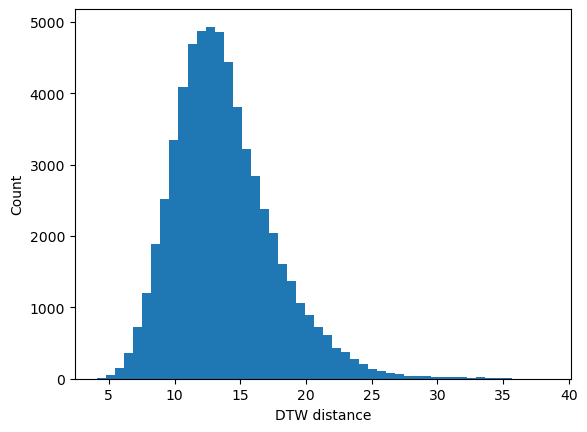

In [12]:
plt.hist(distance_matrix[np.triu_indices_from(distance_matrix, k=1)], bins=50)
plt.xlabel("DTW distance")
plt.ylabel("Count")
plt.show()

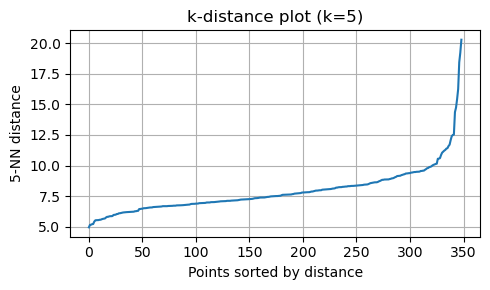

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))
k = 5

nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(distance_matrix)
distances, indices = nbrs.kneighbors(distance_matrix)
k_distances = np.sort(distances[:, -1])

ax.plot(k_distances)
ax.set_ylabel(f"{k}-NN distance")
ax.set_xlabel("Points sorted by distance")
ax.set_title(f"k-distance plot (k={k})")
ax.grid()

plt.tight_layout()
plt.show()

In [14]:
from kneed import KneeLocator

# k_distances should be sorted in ascending order
kneedle = KneeLocator(range(len(k_distances)), k_distances, S=1.0, curve="convex", direction="increasing")
elbow_value = kneedle.knee_y
print(f"Elbow (knee) value: {elbow_value}")

Elbow (knee) value: 9.58696341408188


In [15]:
db = DBSCAN(eps=elbow_value, min_samples=5, metric='precomputed')
labels = db.fit_predict(distance_matrix)
print(f"Number of clusters (excluding noise): {len(set(labels)) - (1 if -1 in labels else 0)}")
print(f"Number of outliers (noise points): {np.sum(labels == -1)}")
print(f"Cluster labels: {np.unique(labels)}")

Number of clusters (excluding noise): 1
Number of outliers (noise points): 24
Cluster labels: [-1  0]


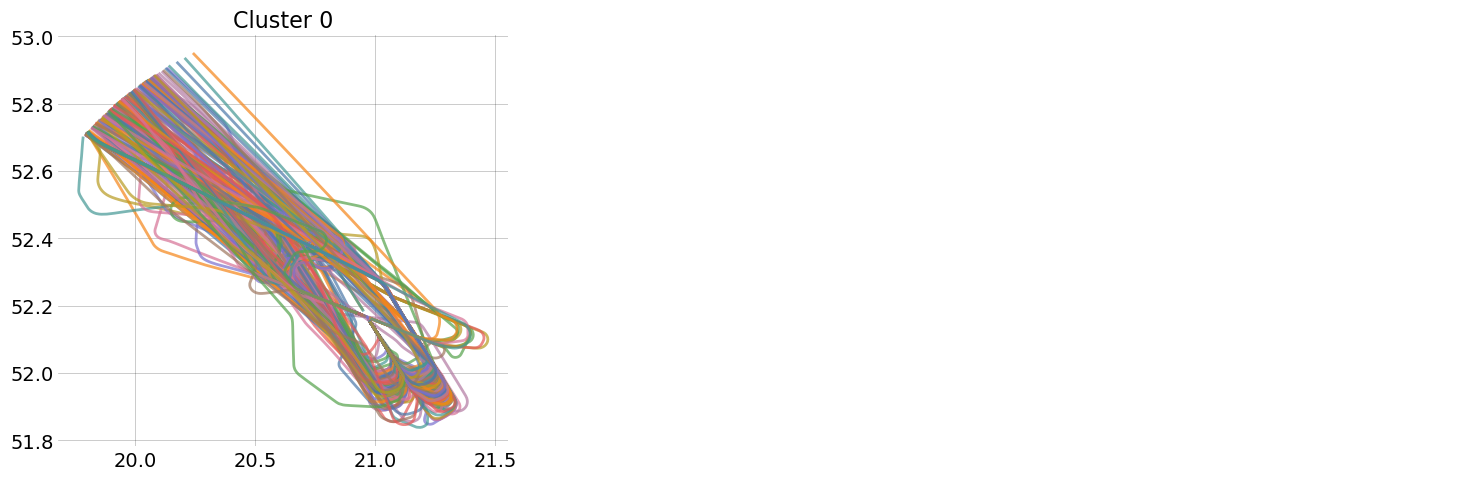

In [16]:
unique_labels = [label for label in np.unique(labels) if label != -1]
n = len(unique_labels)
cols = 3
rows = (n + cols - 1) // cols

with plt.style.context('traffic'):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()
    for i, label in enumerate(unique_labels):
        cluster_flights = [flights[j] for j in range(len(labels)) if labels[j] == label]
        for flight in cluster_flights:
            flight.plot(ax=axes[i], linewidth=2, alpha=0.7)
        axes[i].set_title(f'Cluster {label}')
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

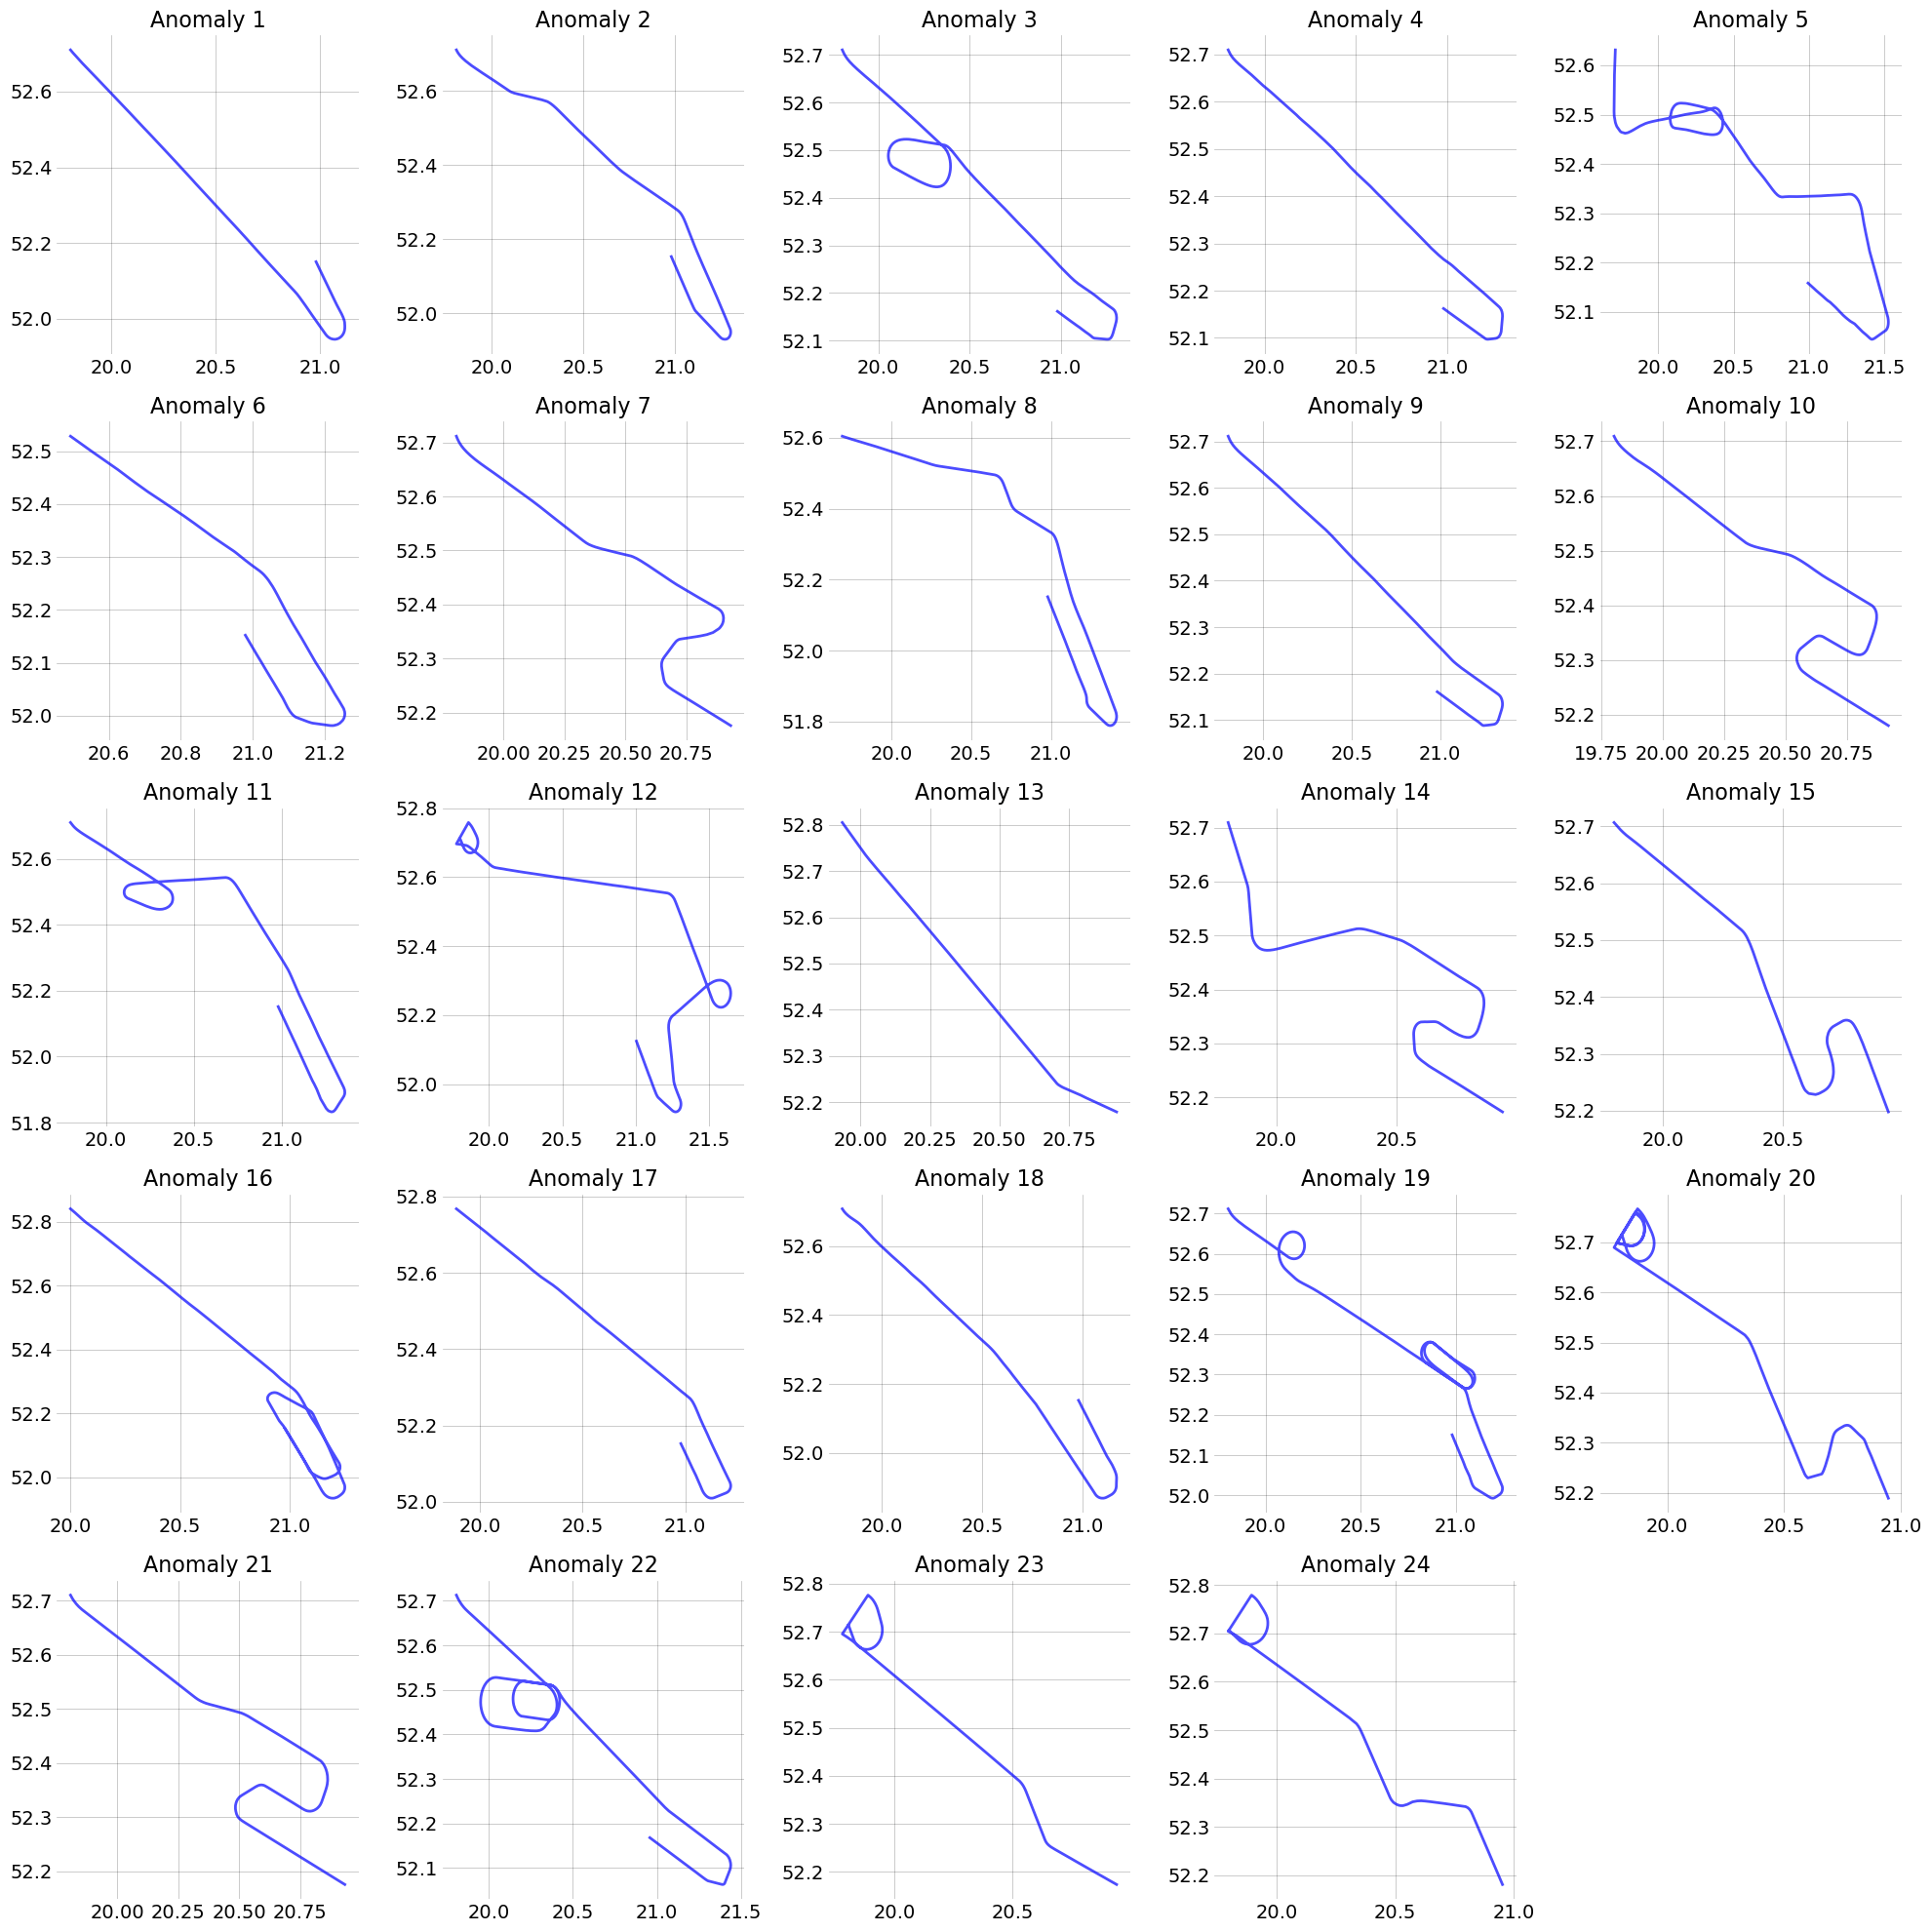

In [17]:
outlier_indices = np.where(labels == -1)[0]
anomaly_flights = [flights[i] for i in outlier_indices]
n = len(anomaly_flights)
cols = 5
rows = (n + cols - 1) // cols

with plt.style.context('traffic'):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()
    for i, flight in enumerate(anomaly_flights):
        flight.plot(ax=axes[i], color='blue', linewidth=2, alpha=0.7)
        axes[i].set_title(f'Anomaly {i+1}')
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# Another callsigns

In [18]:
flights_by_callsign = {}
sequences_by_callsign = {}
for flight in tqdm(traffic):
    callsign = flight.callsign
    if callsign not in flights_by_callsign:
        flights_by_callsign[callsign] = []
        sequences_by_callsign[callsign] = []
    flights_by_callsign[callsign].append(flight)
    sequences_by_callsign[callsign].append(get_sequence(flight.resample("4s")))

100%|██████████| 6744/6744 [01:42<00:00, 65.57it/s]


Callsign: LOT3904, Clusters: 1, Noise: 15
Cluster labels: [-1  0]


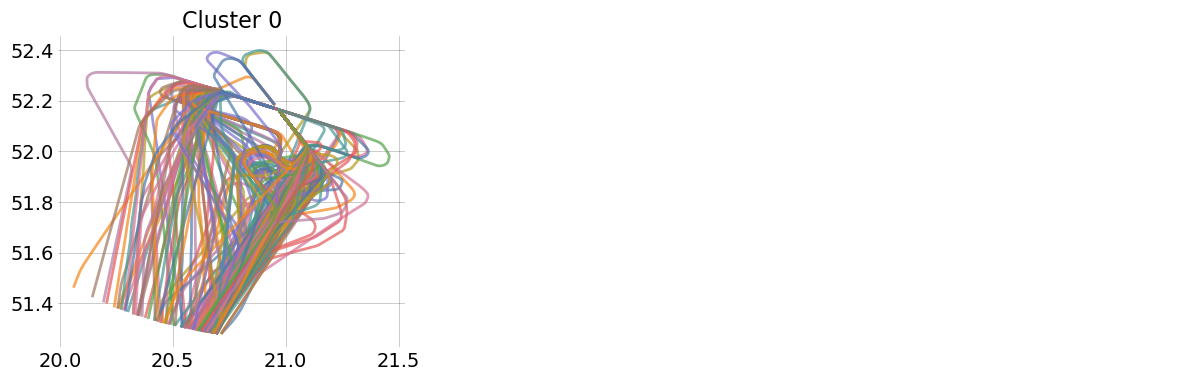

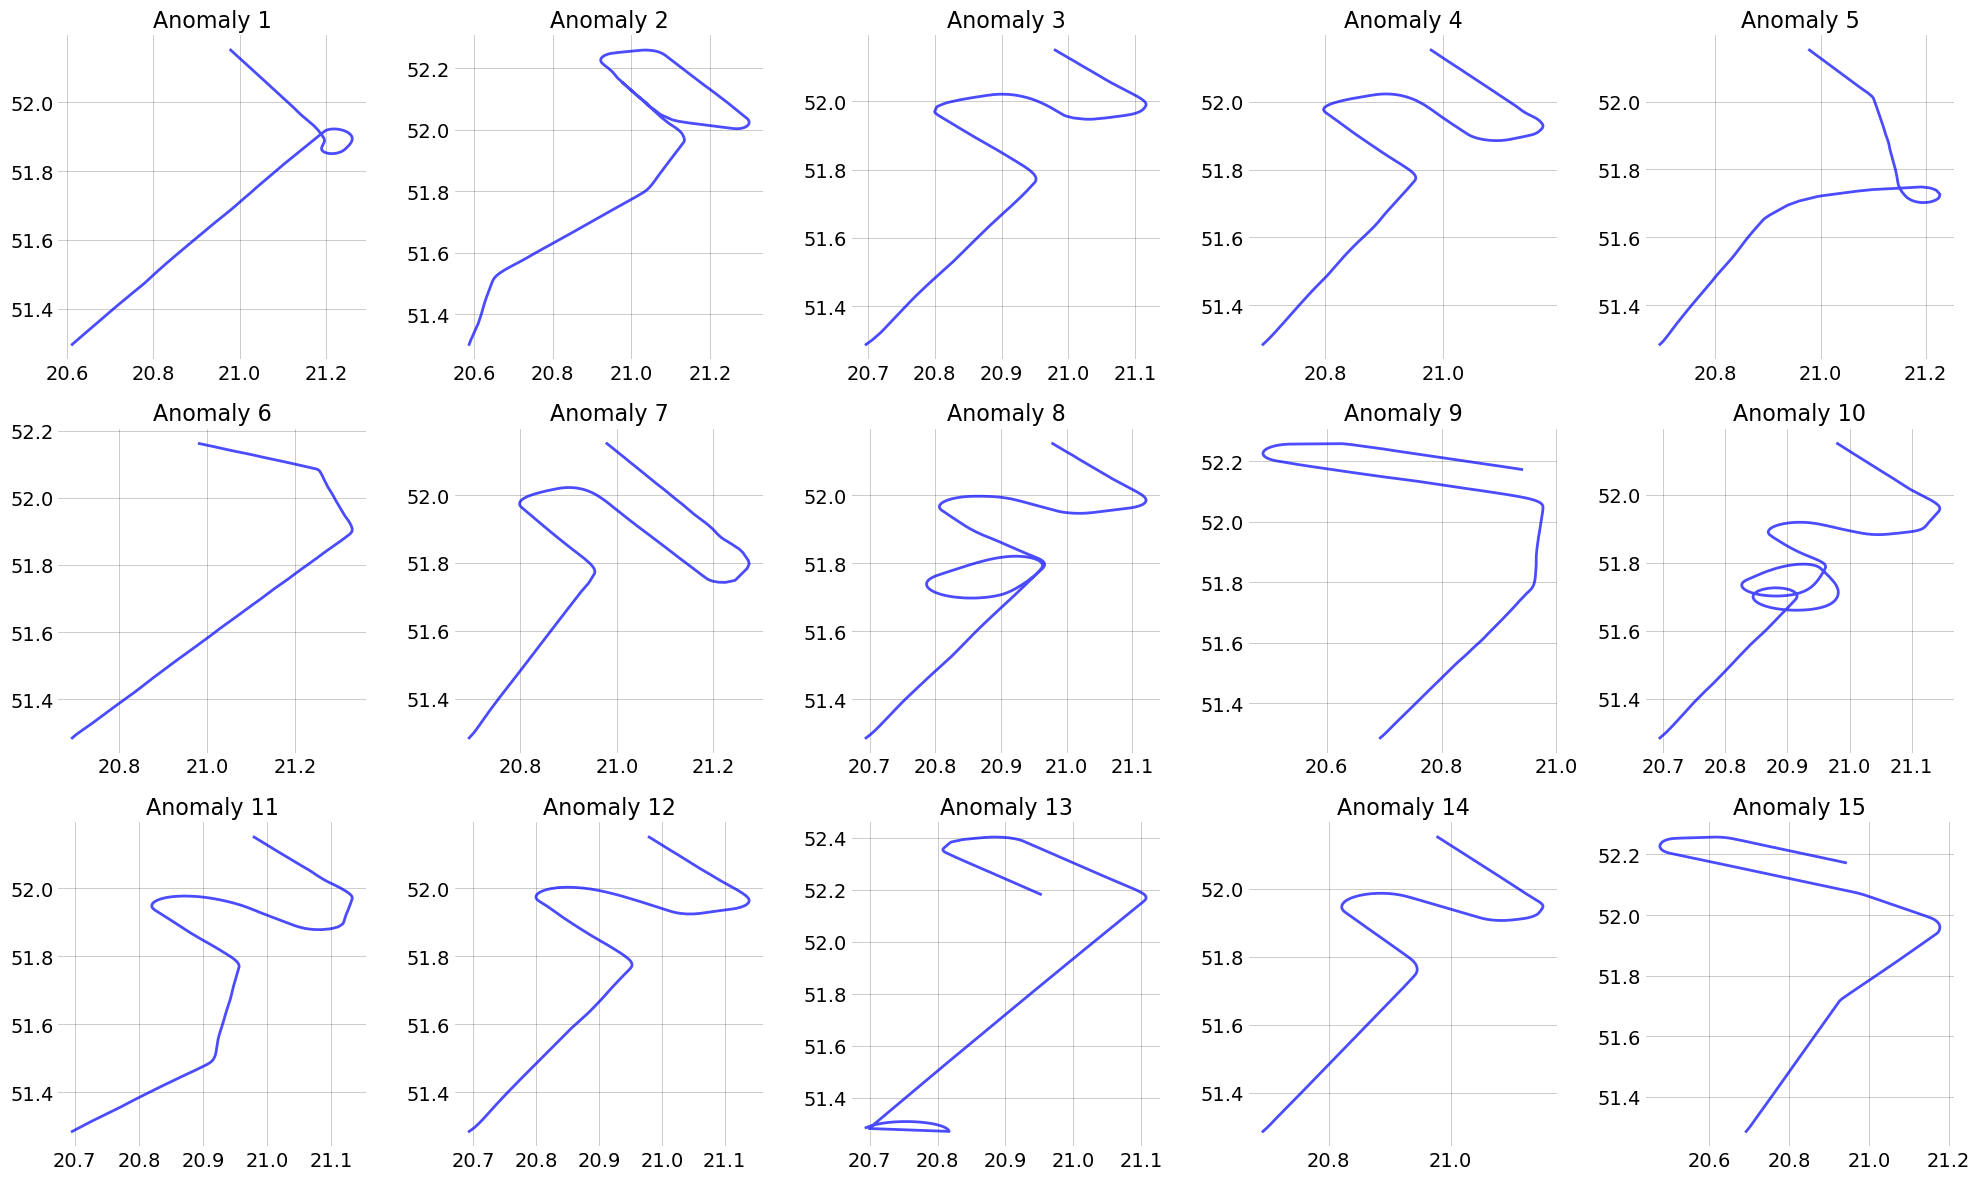

Callsign: LOT3VM, Clusters: 1, Noise: 12
Cluster labels: [-1  0]


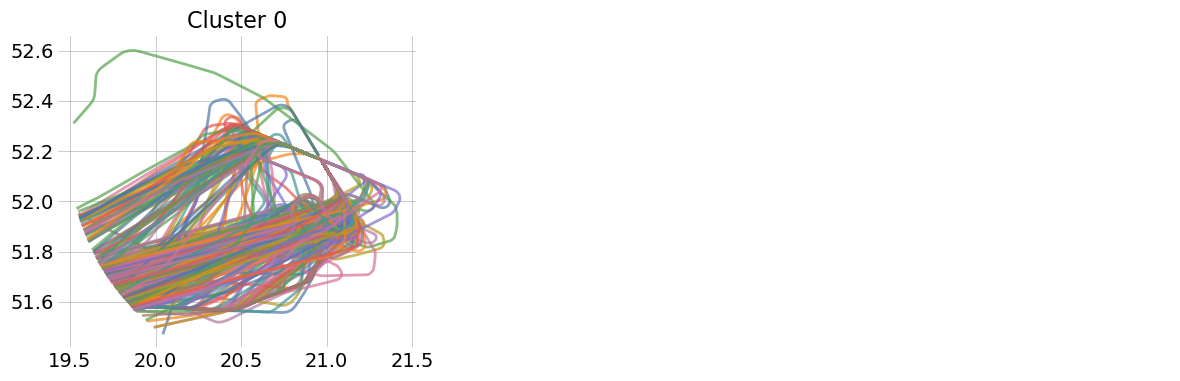

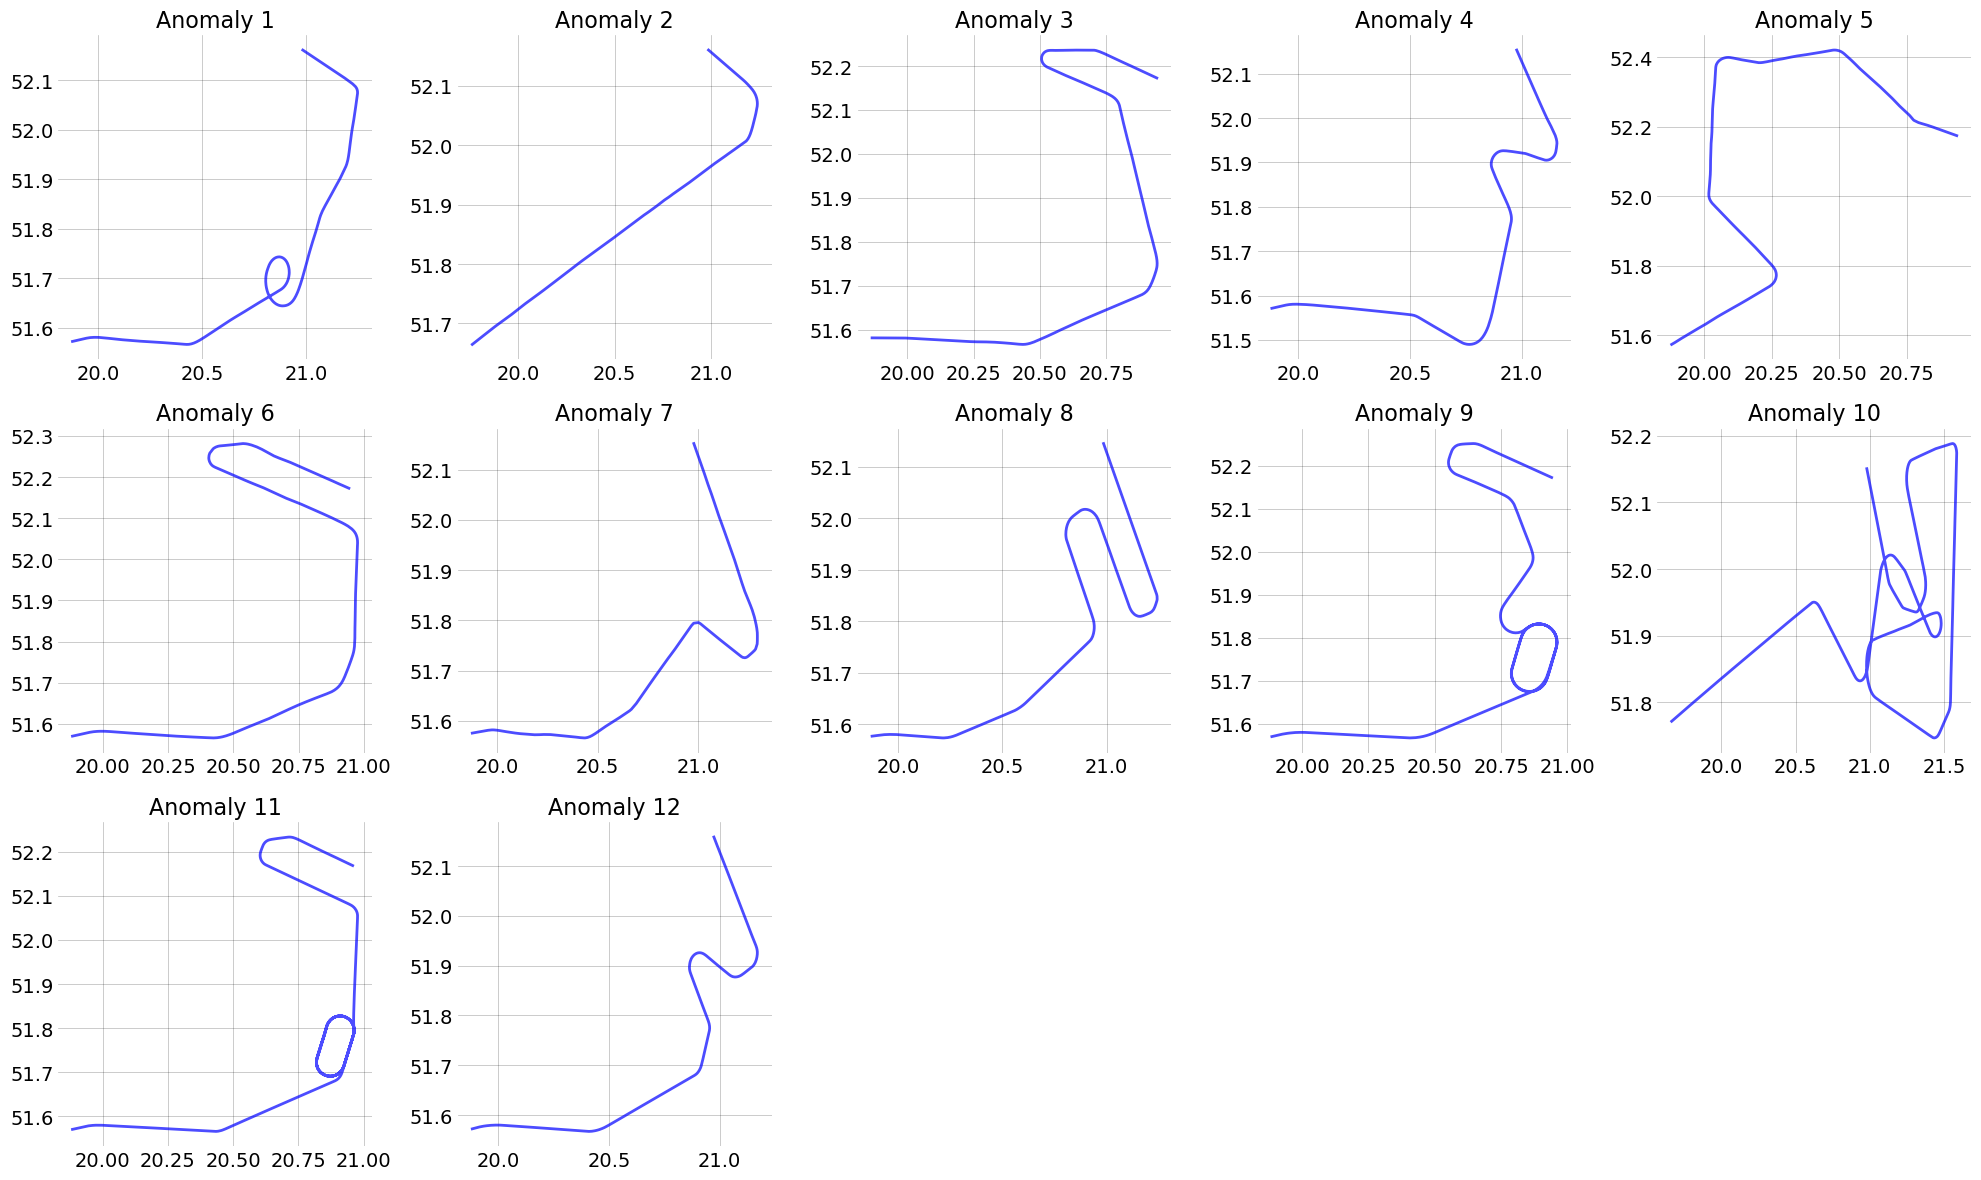

Callsign: LOT3VT, Clusters: 1, Noise: 24
Cluster labels: [-1  0]


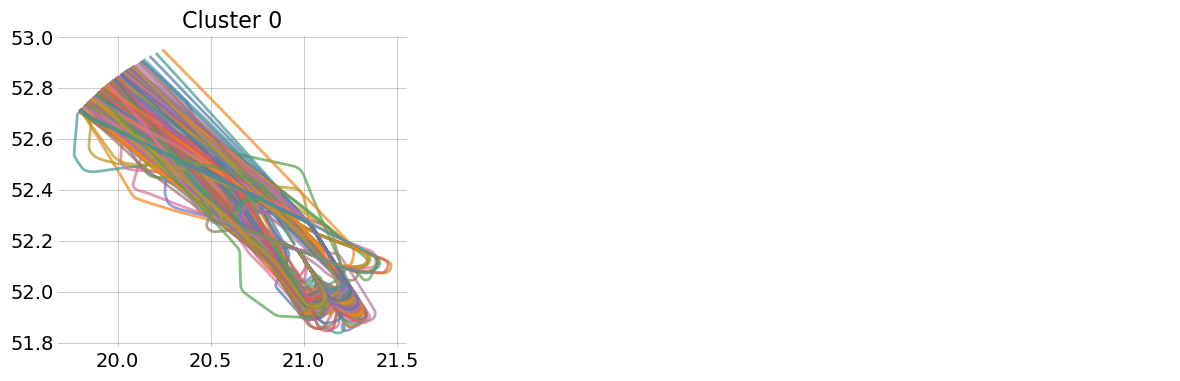

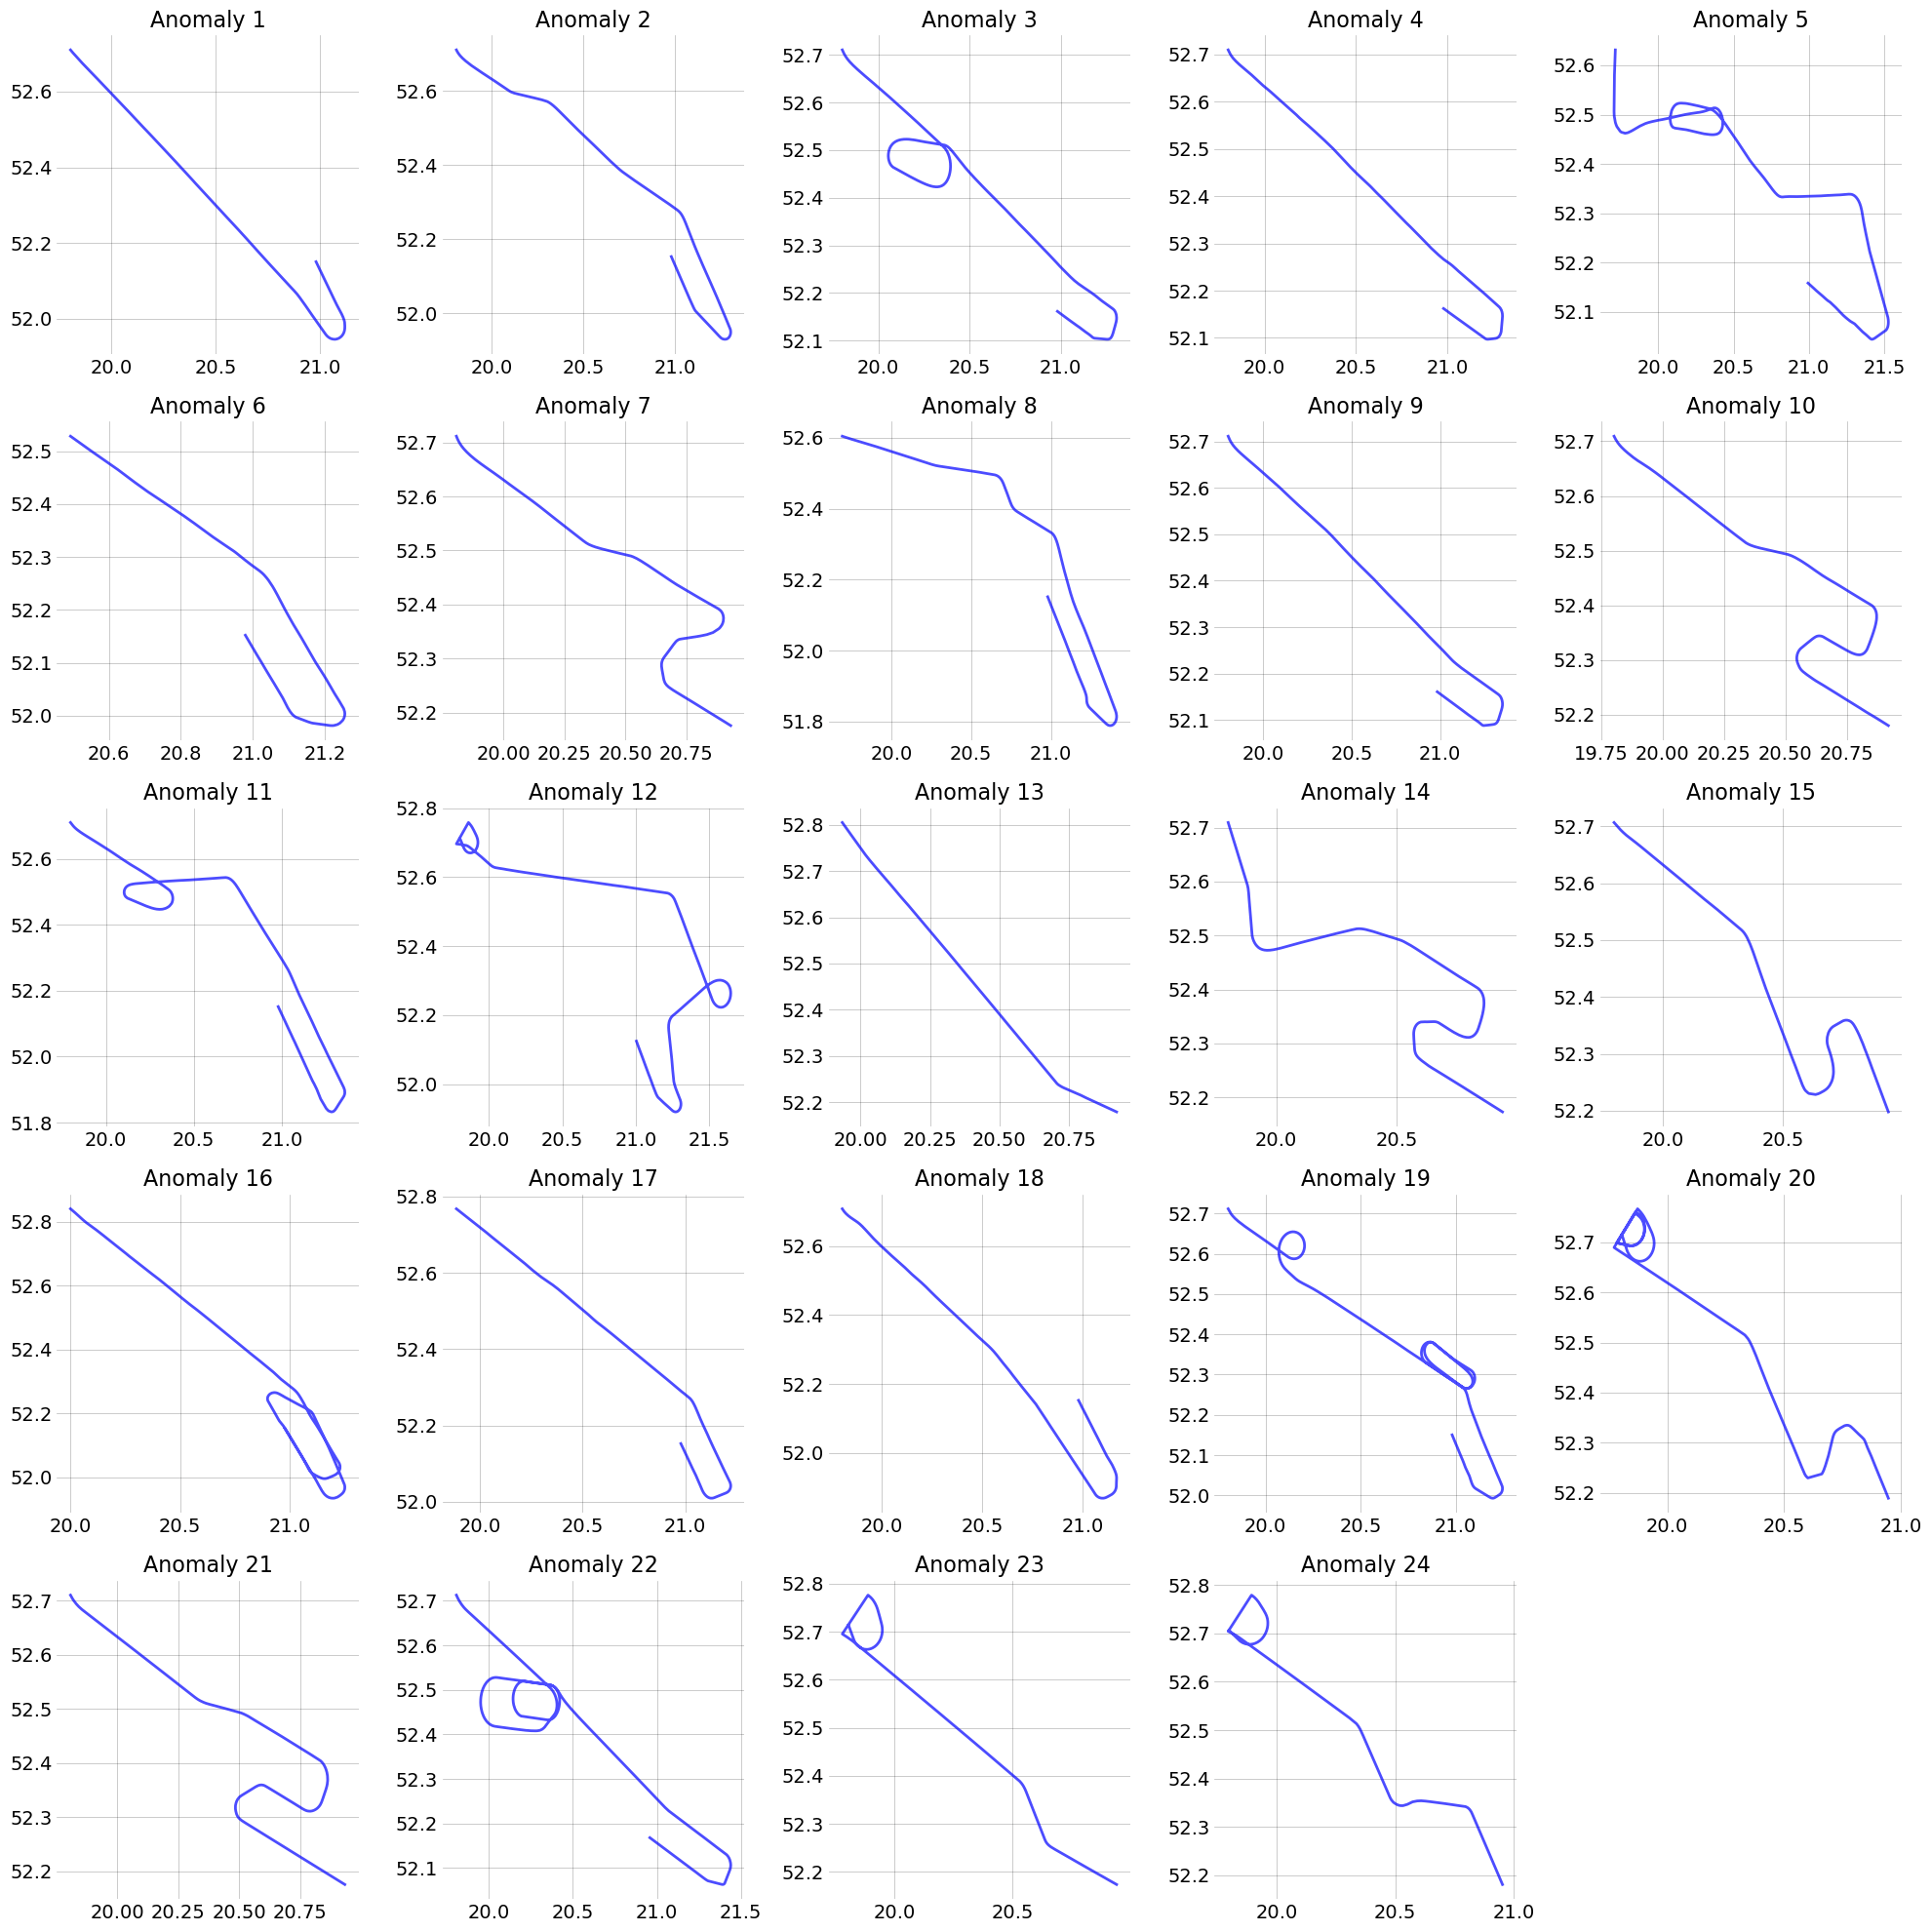

Callsign: FIN1143, Clusters: 1, Noise: 5
Cluster labels: [-1  0]


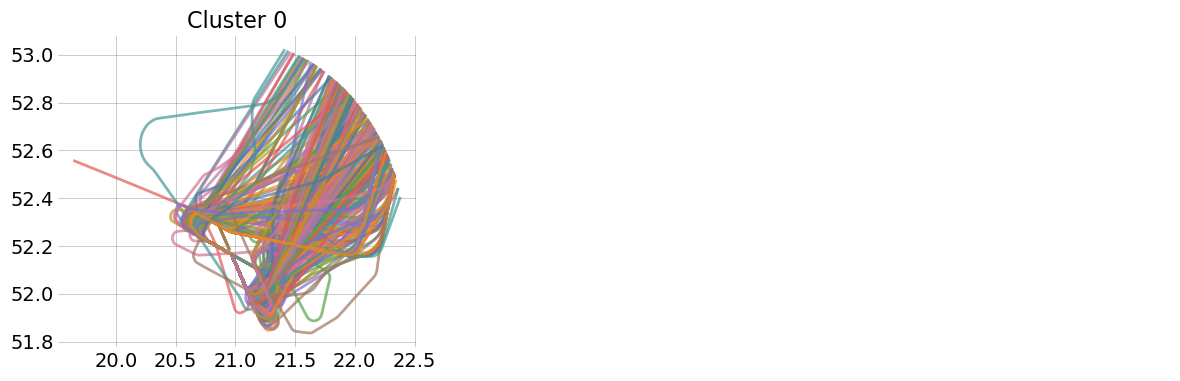

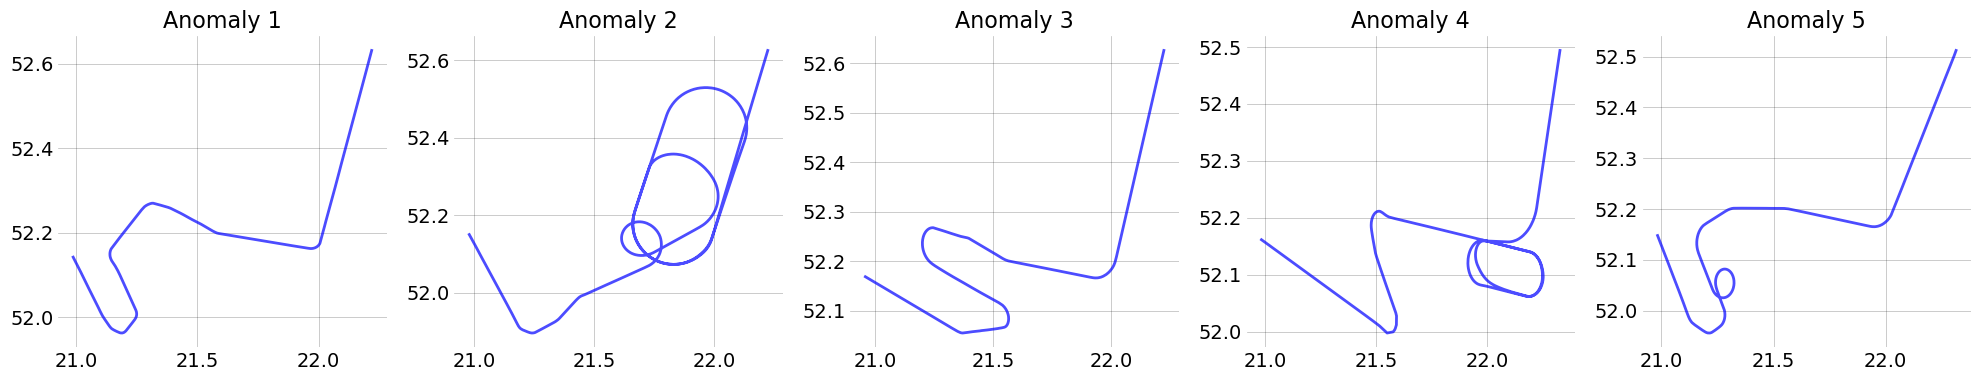

Callsign: FIN8AL, Clusters: 1, Noise: 8
Cluster labels: [-1  0]


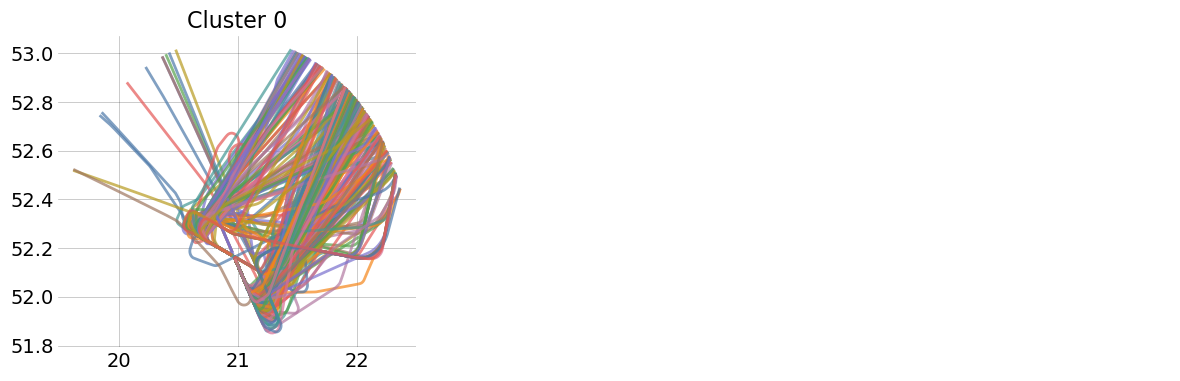

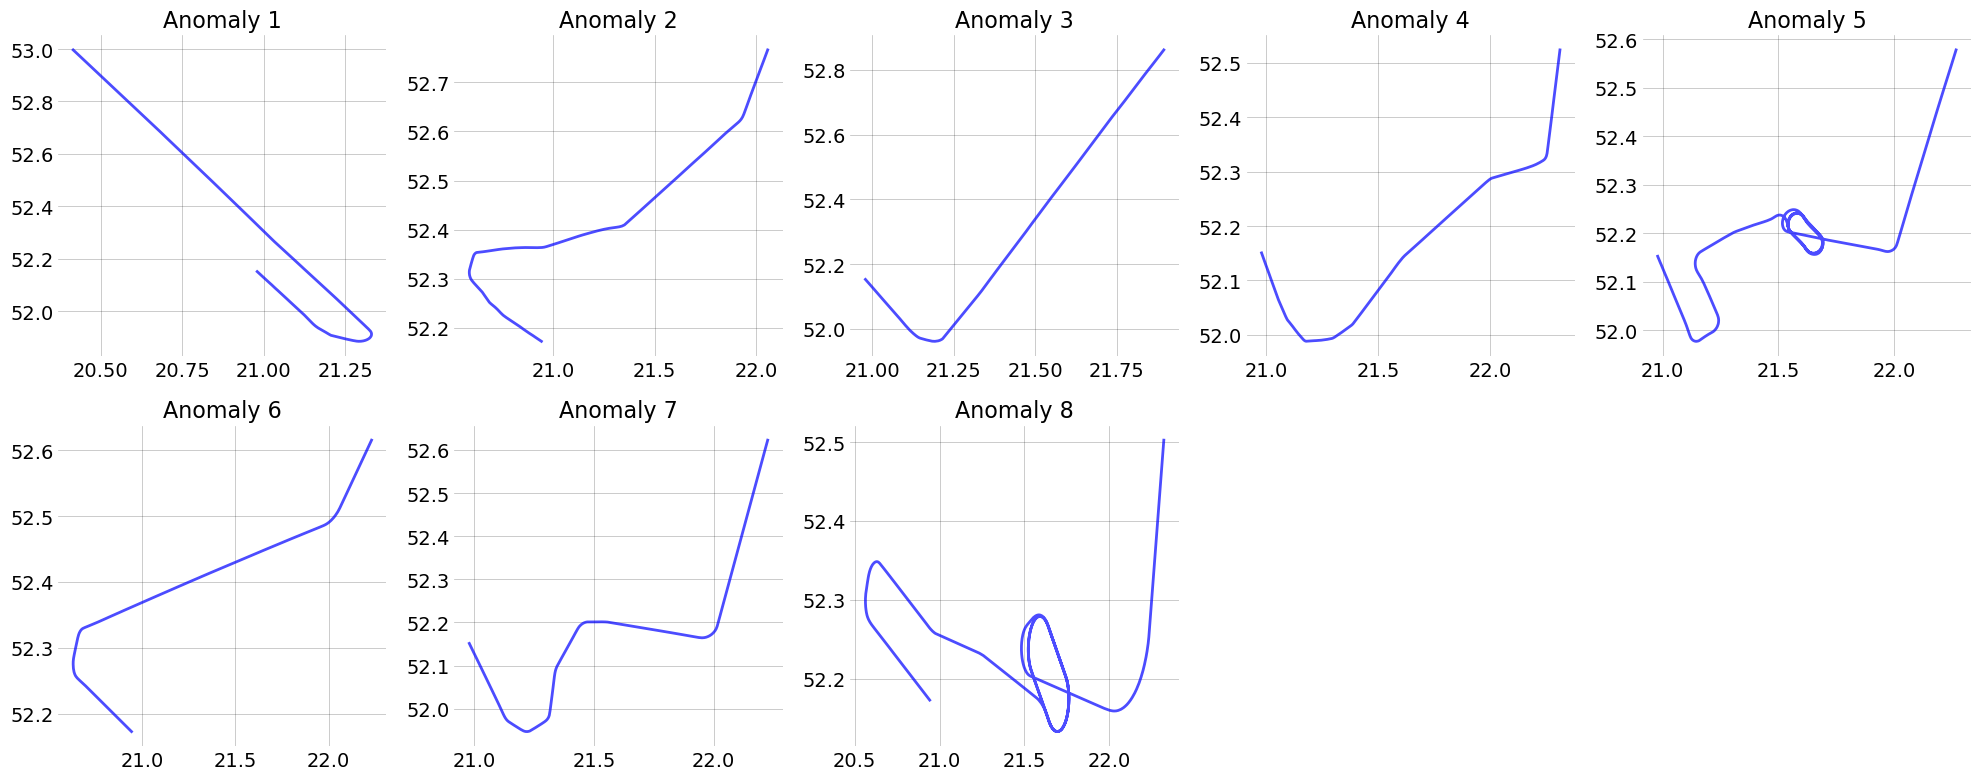

Callsign: KLM85R, Clusters: 1, Noise: 14
Cluster labels: [-1  0]


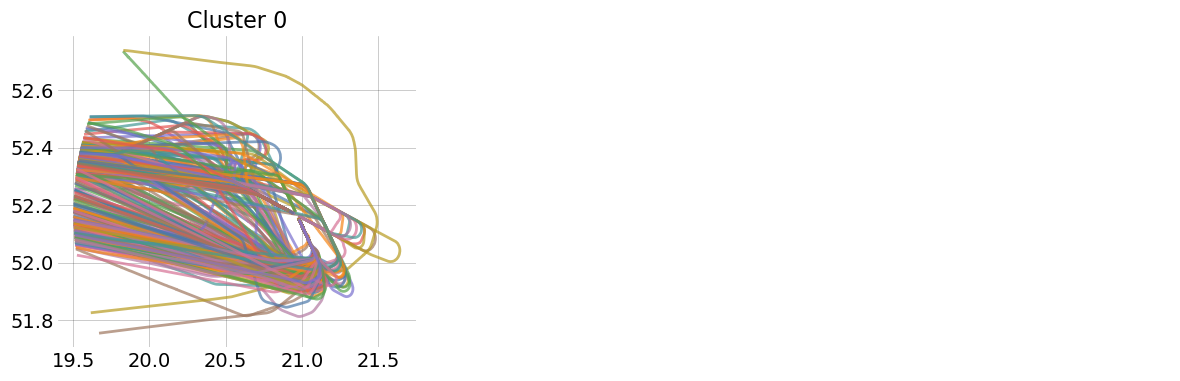

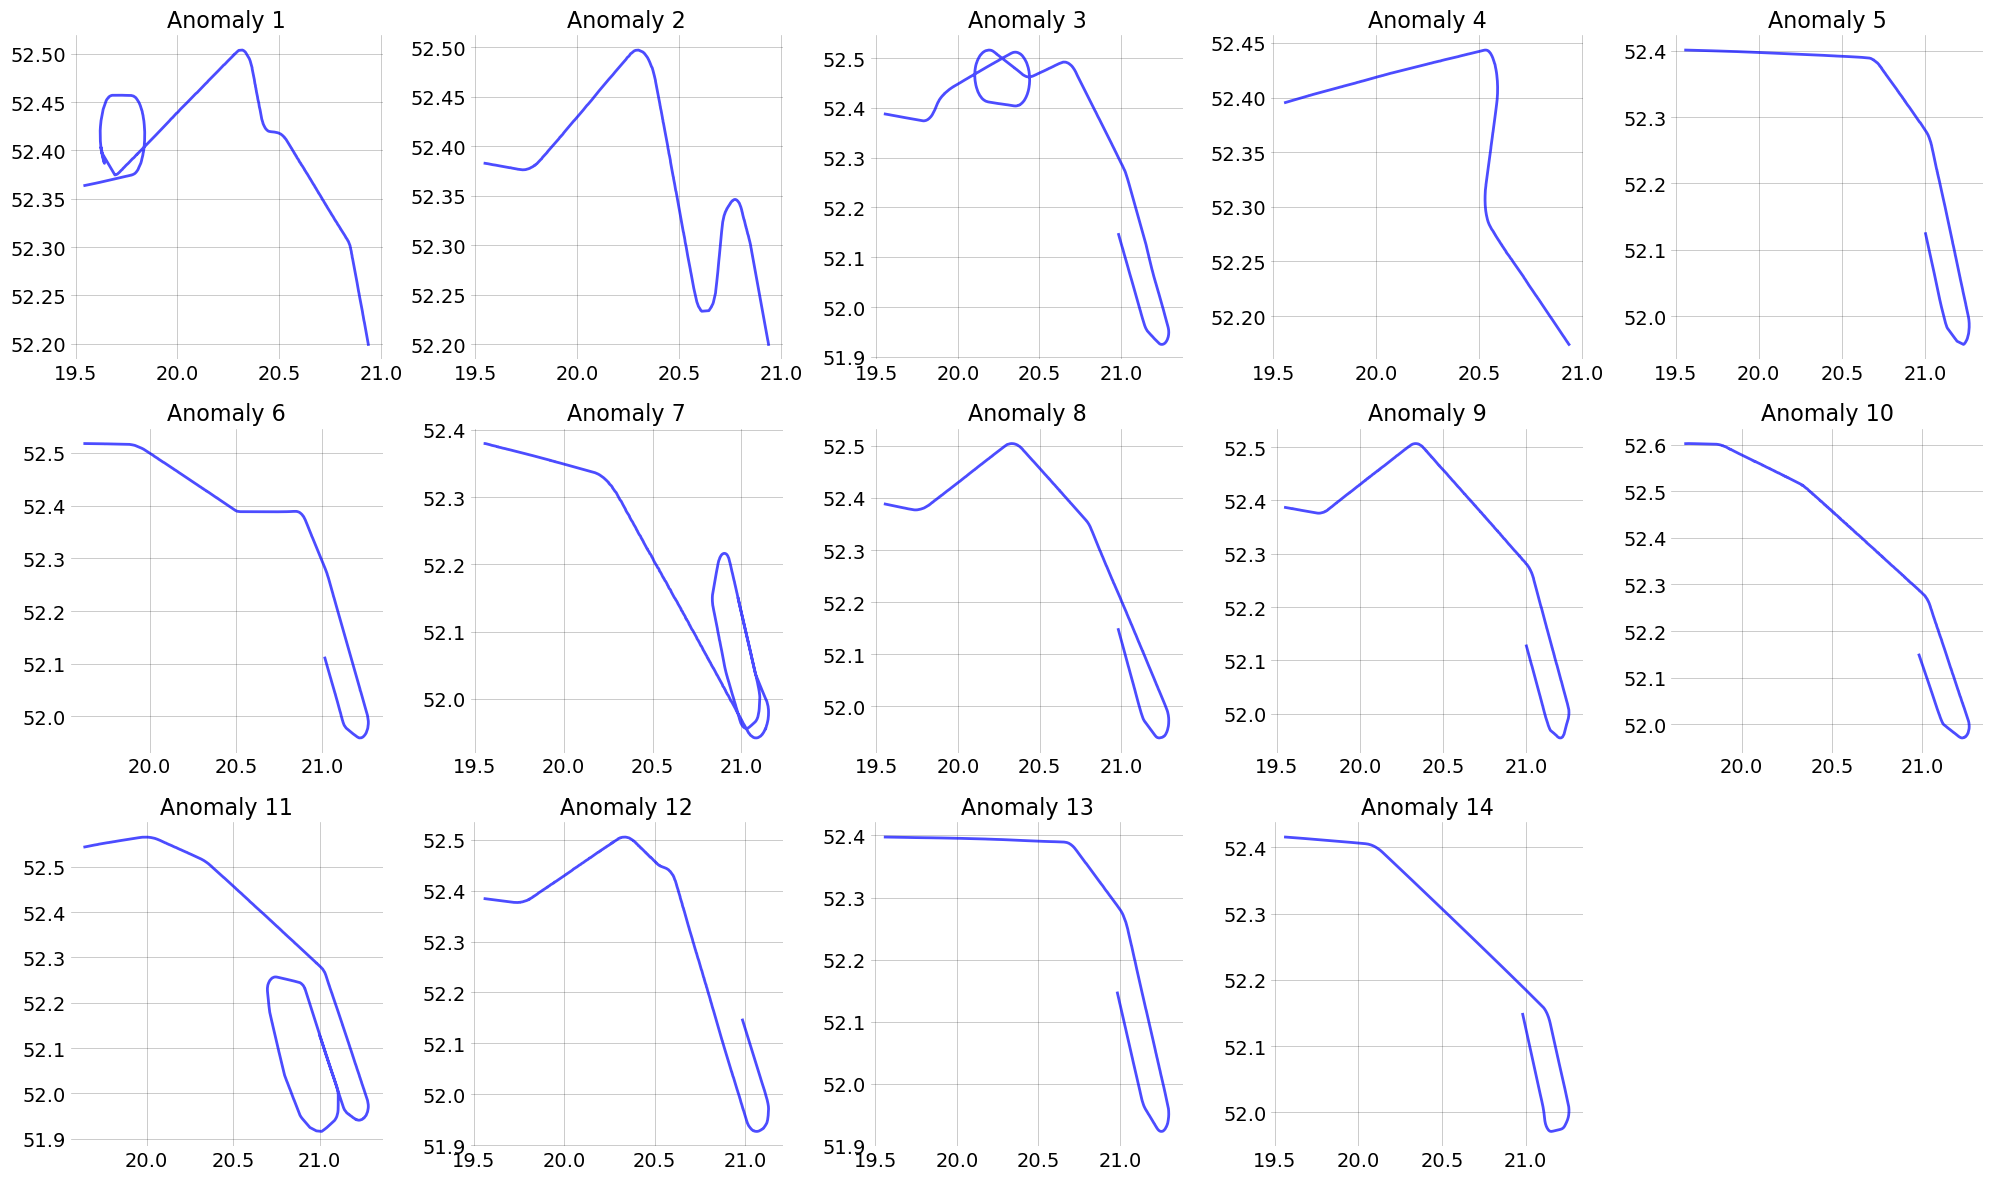

Callsign: LOT5MG, Clusters: 1, Noise: 18
Cluster labels: [-1  0]


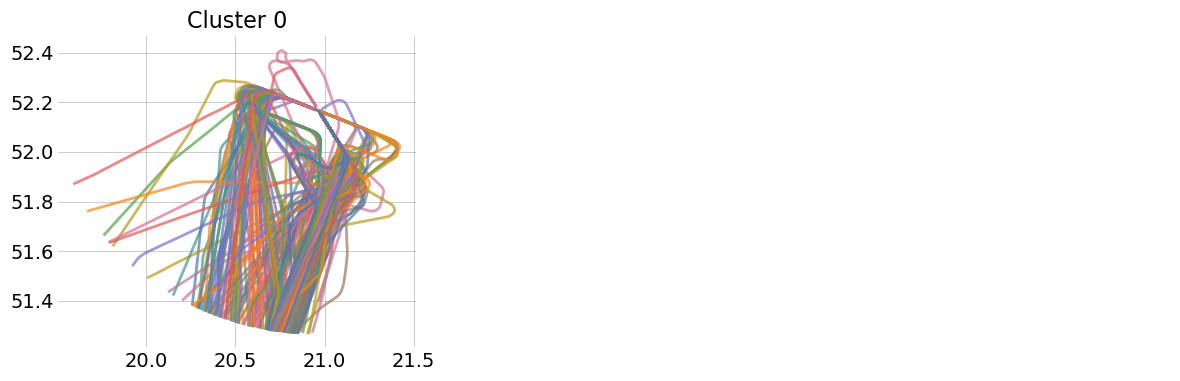

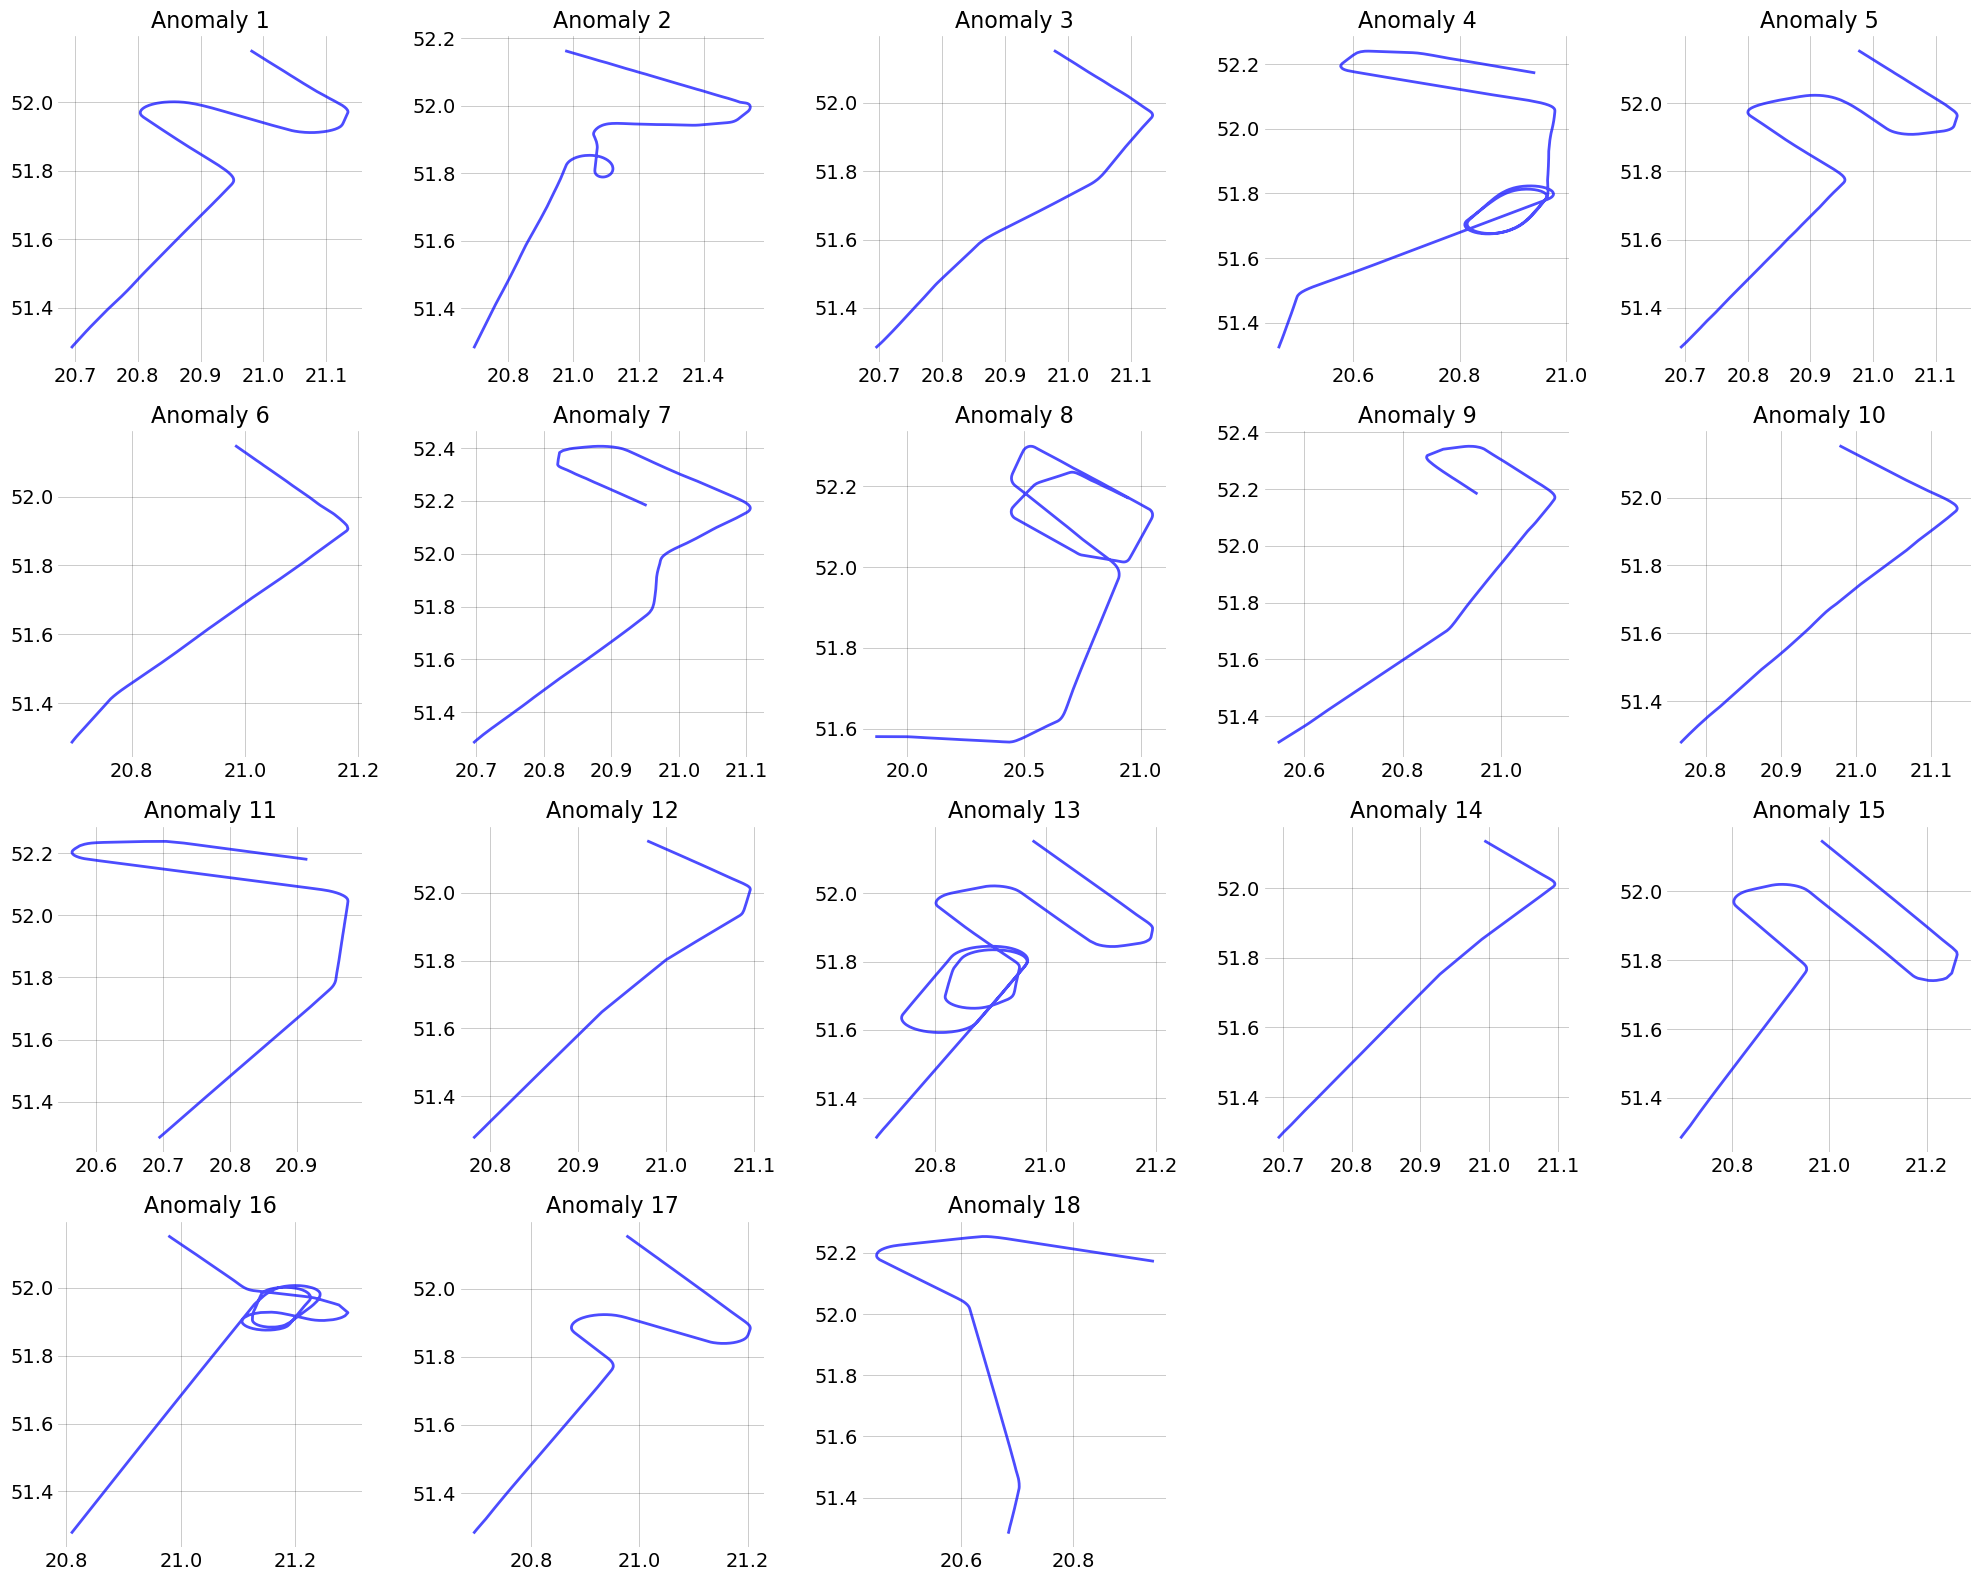

Callsign: LOT7YC, Clusters: 1, Noise: 14
Cluster labels: [-1  0]


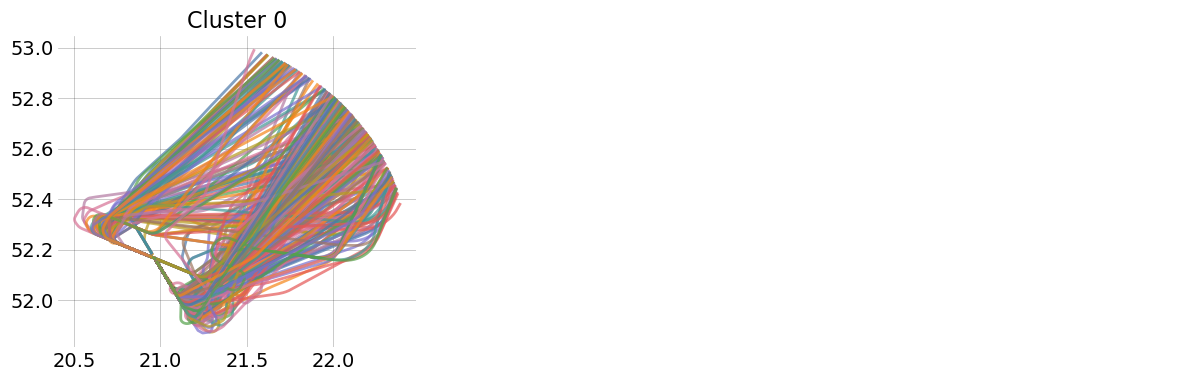

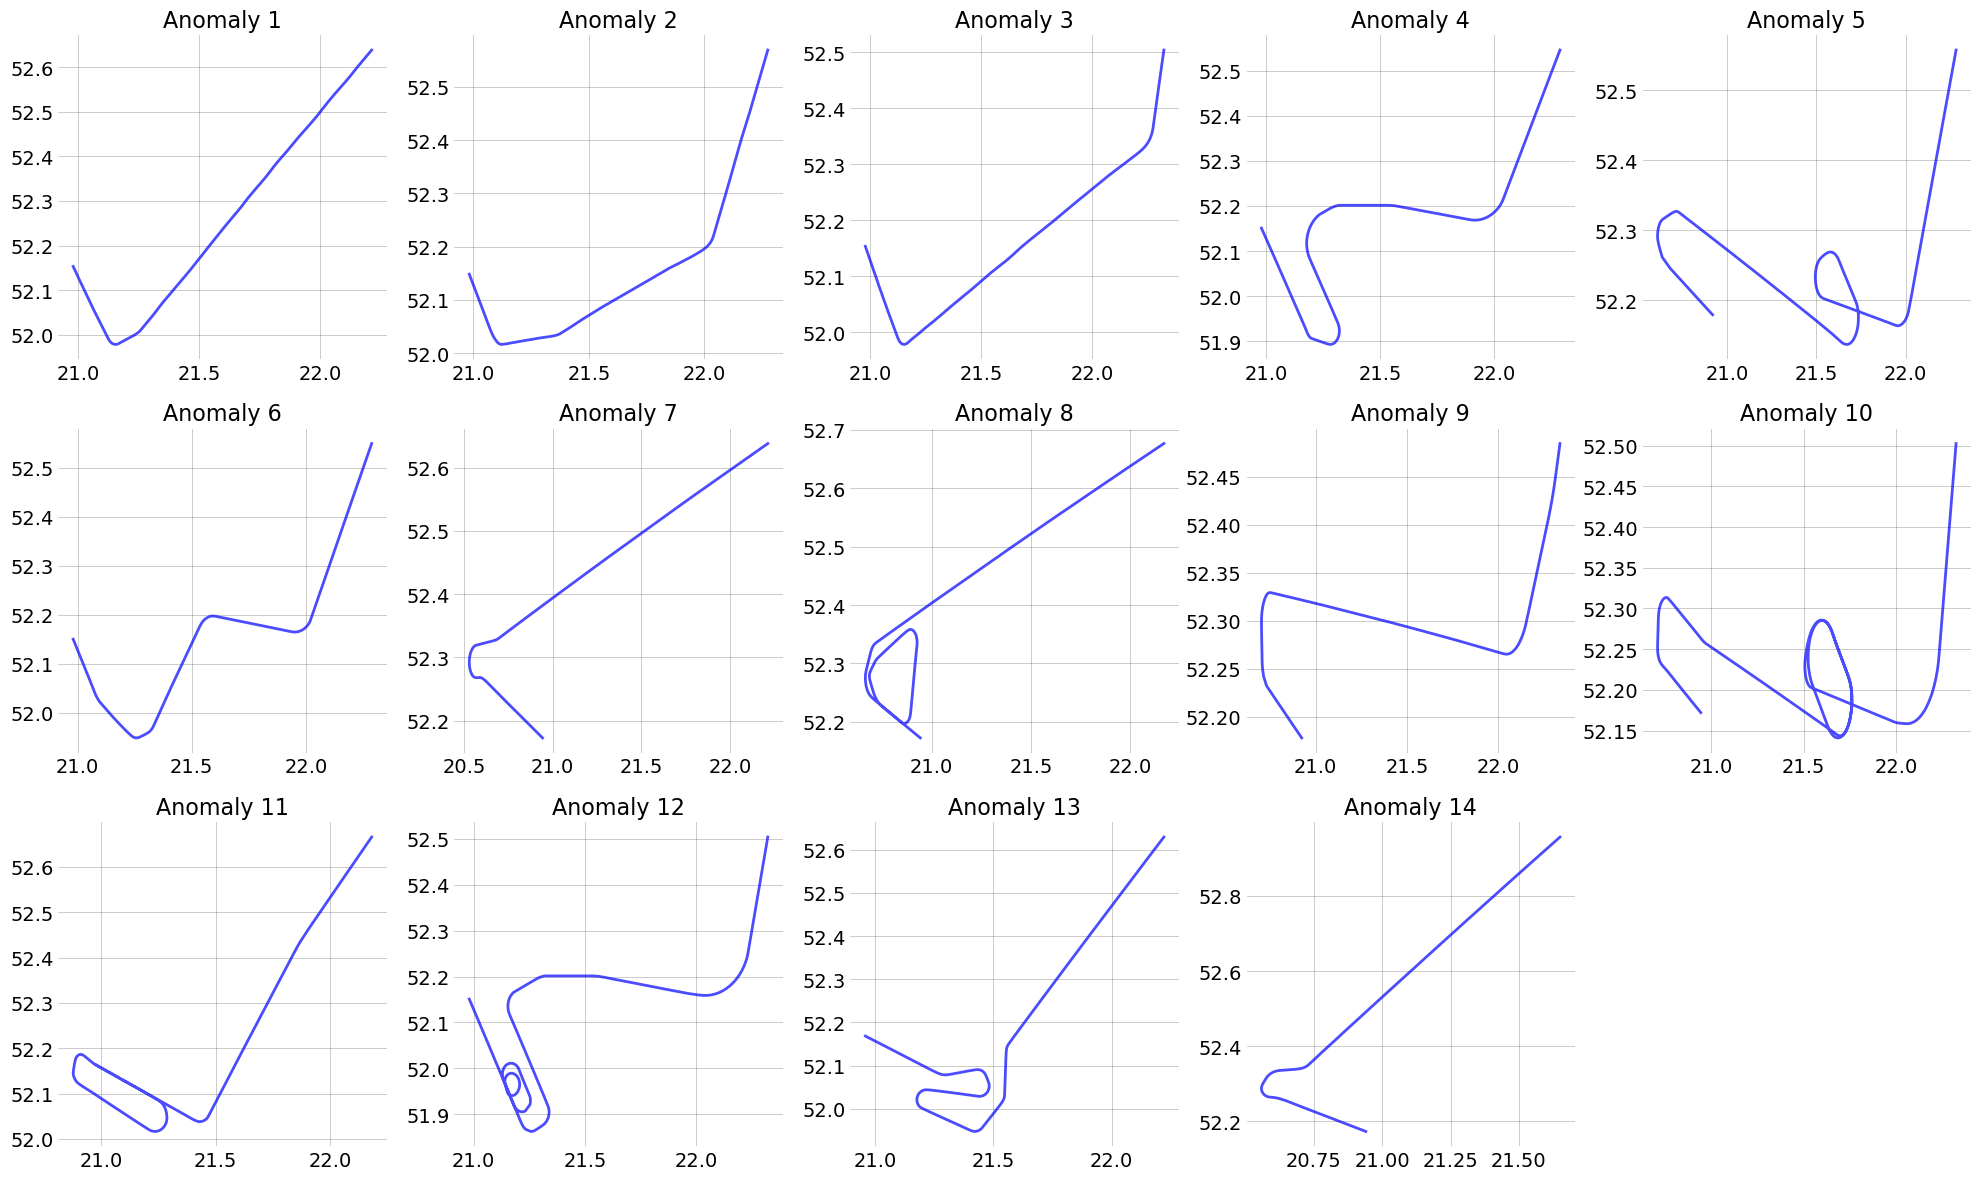

Callsign: LOT8AU, Clusters: 1, Noise: 14
Cluster labels: [-1  0]


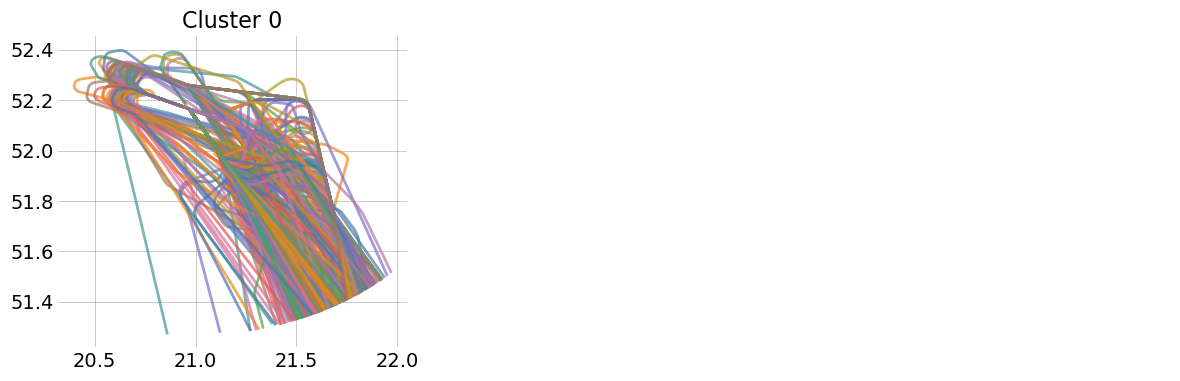

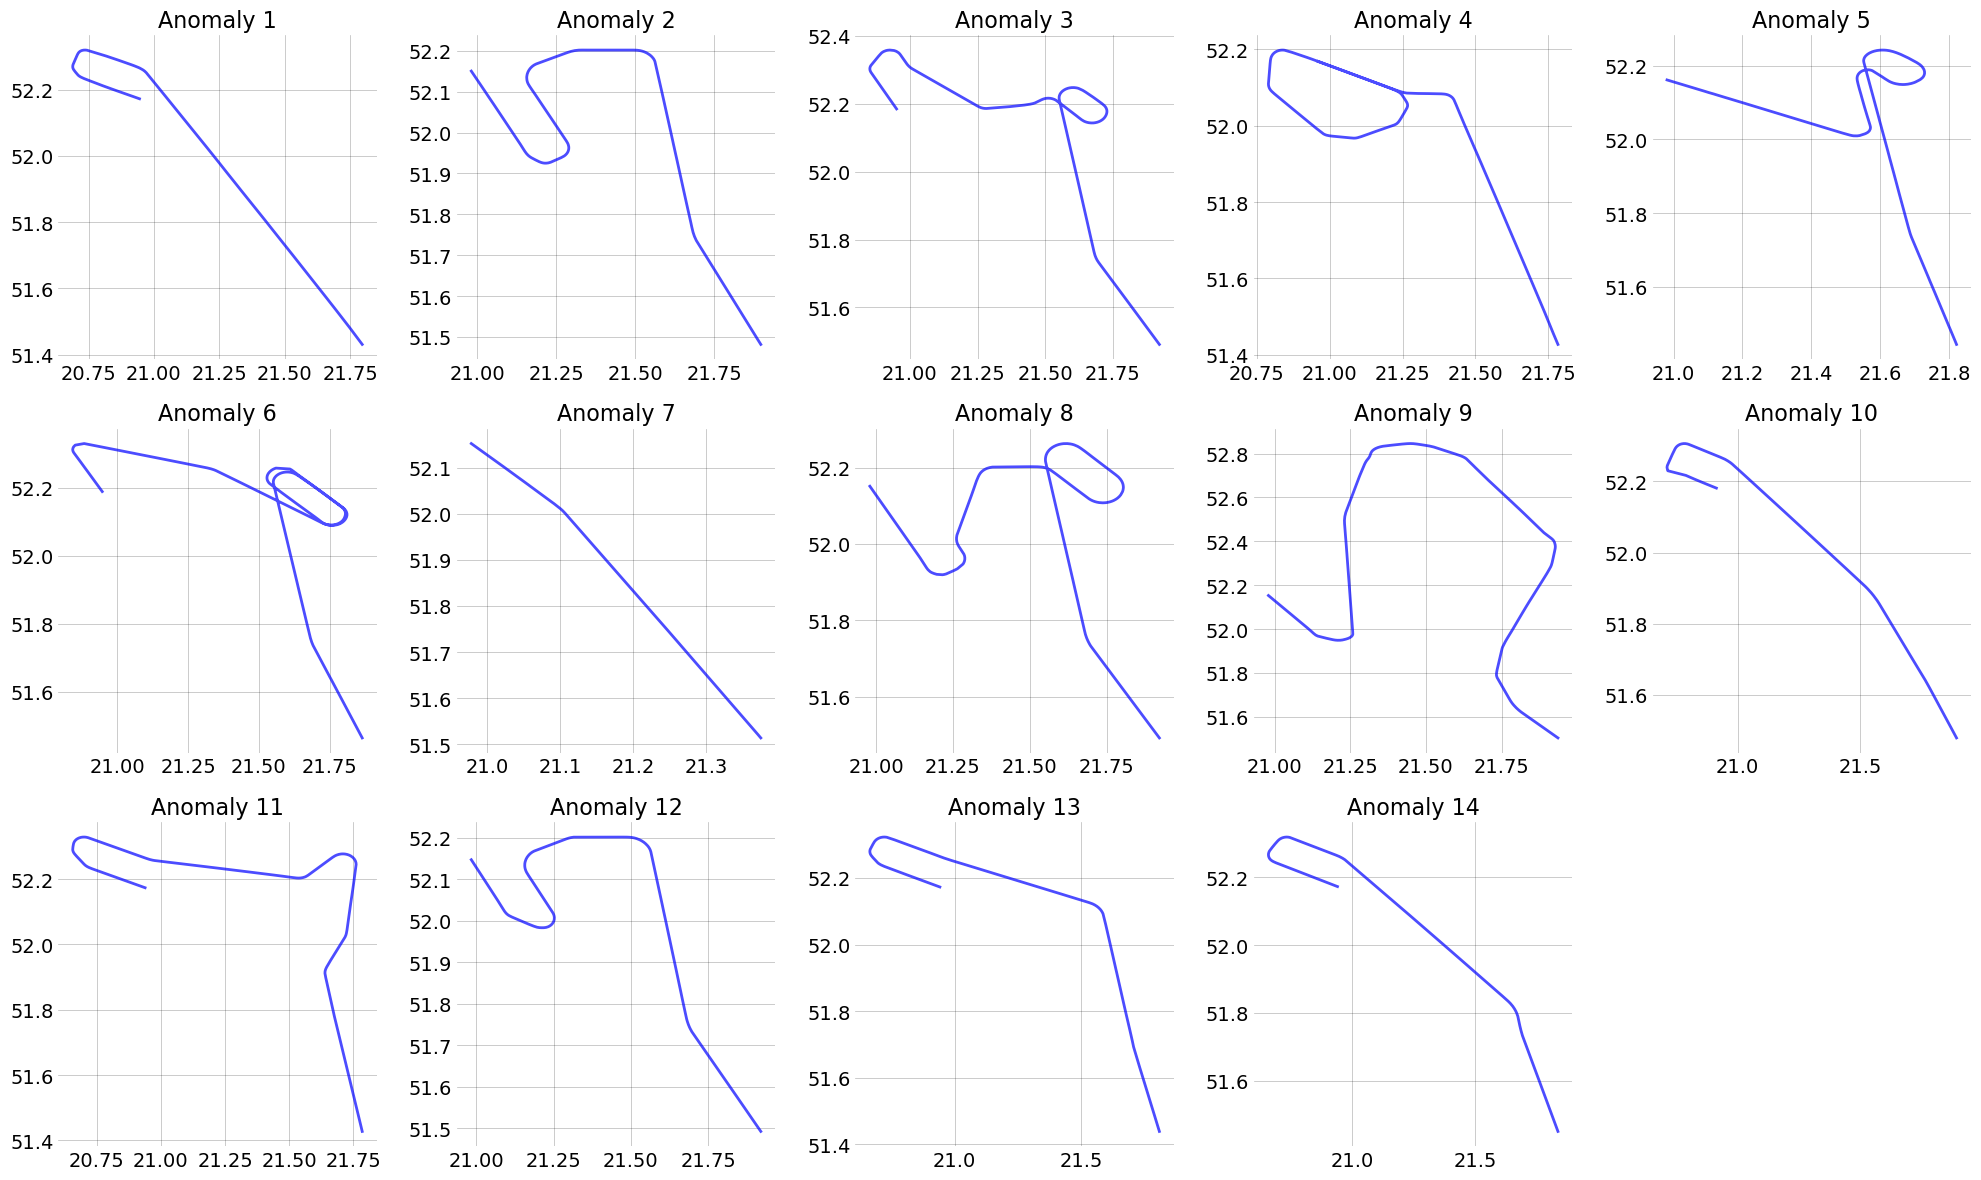

Callsign: LOT9PU, Clusters: 1, Noise: 14
Cluster labels: [-1  0]


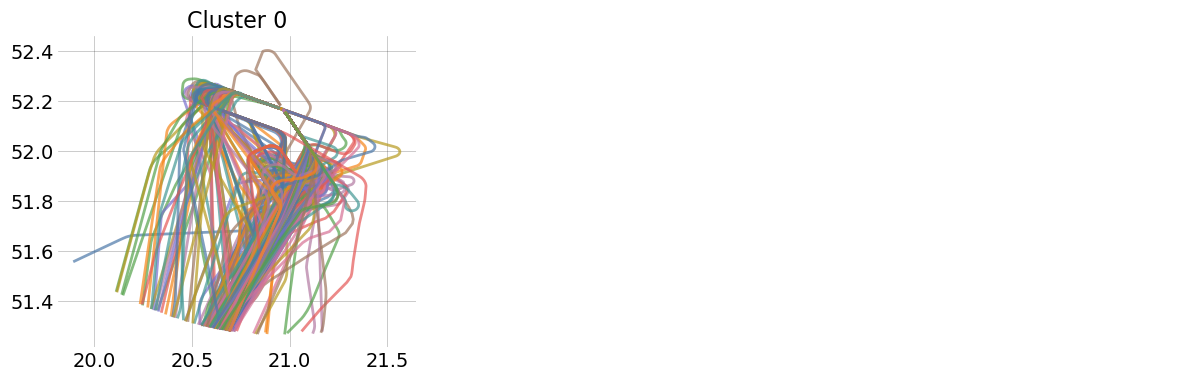

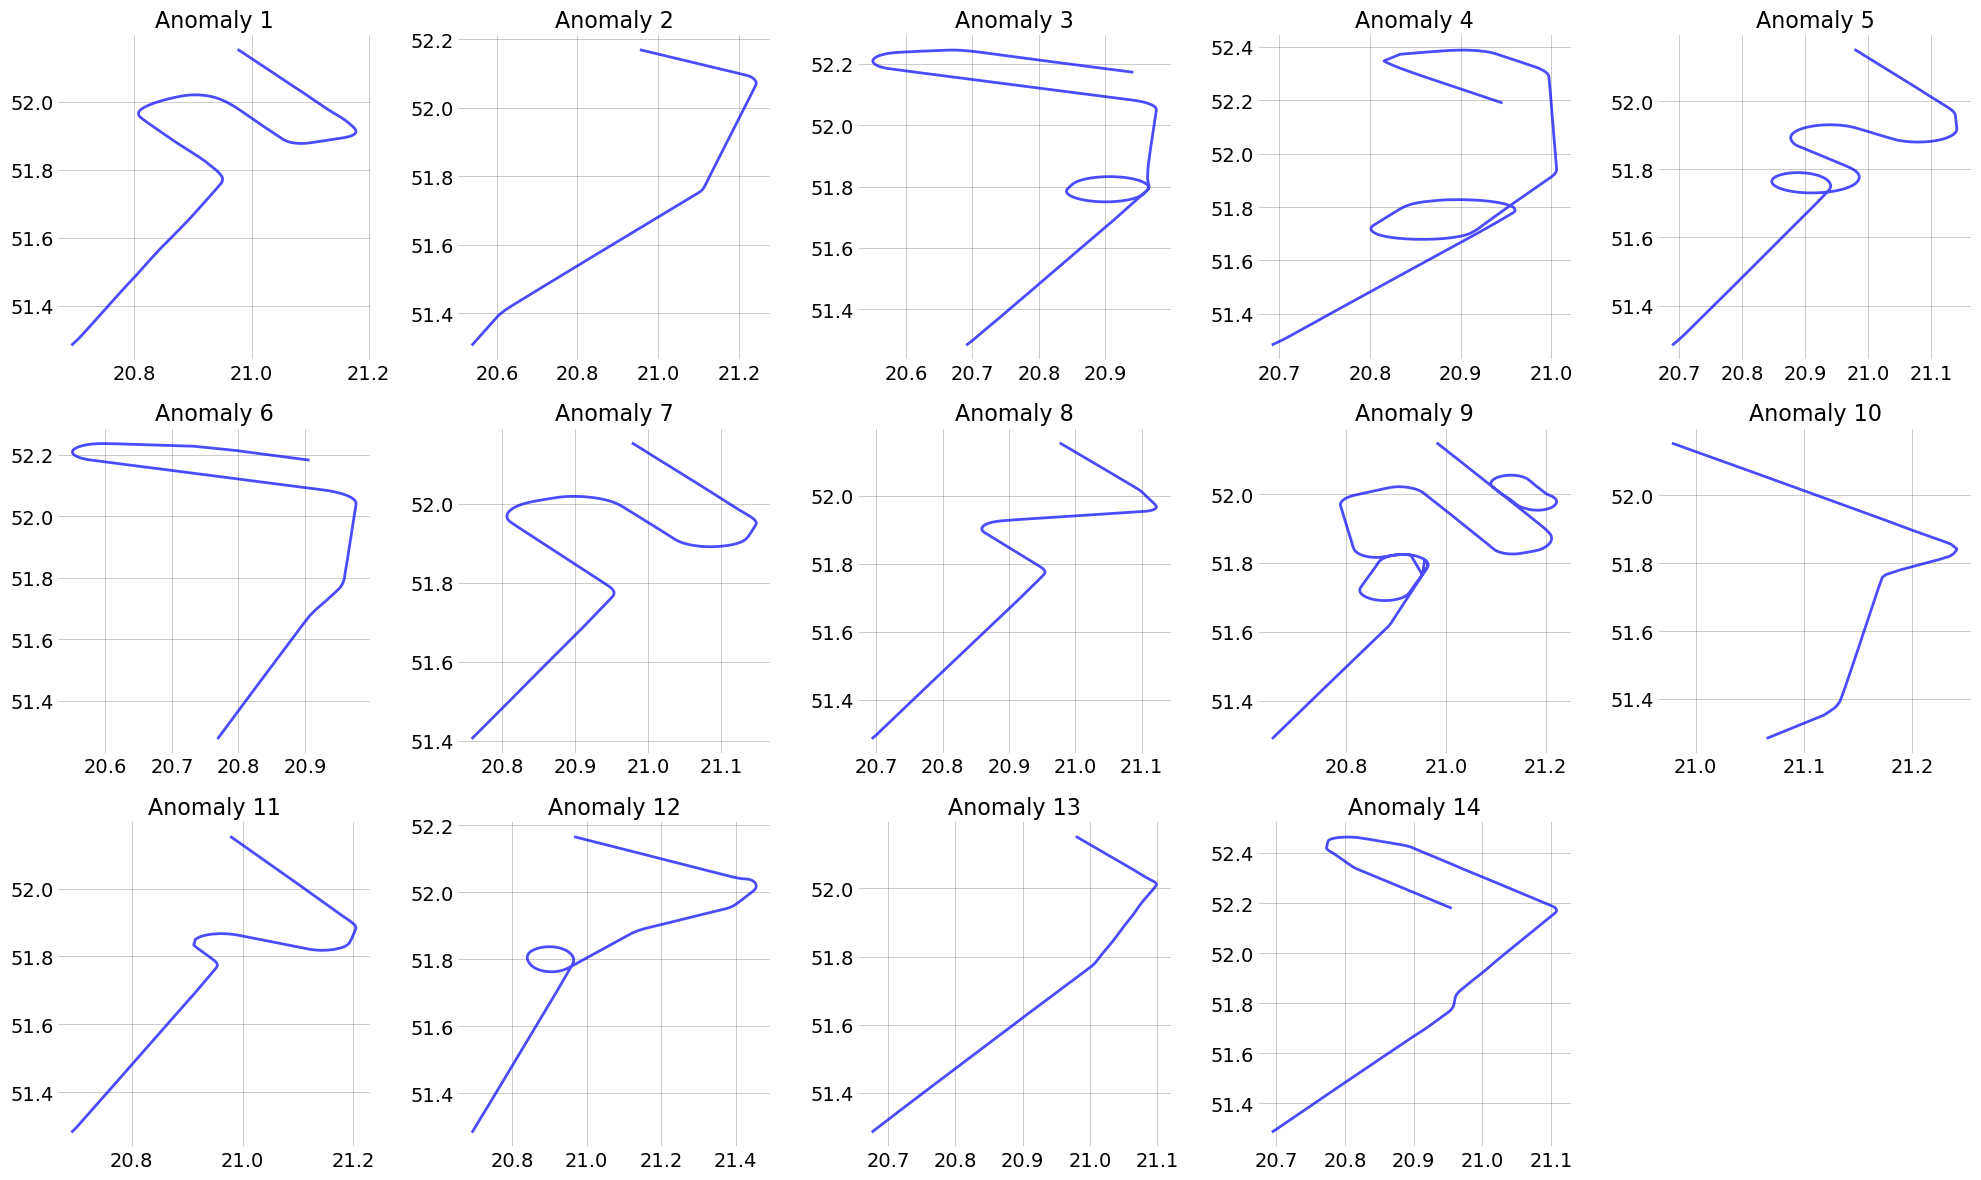

Callsign: LOT774, Clusters: 1, Noise: 15
Cluster labels: [-1  0]


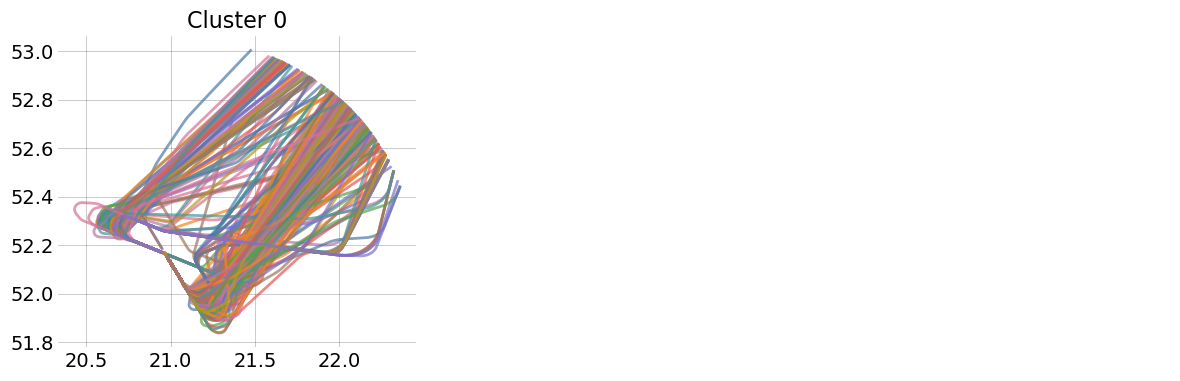

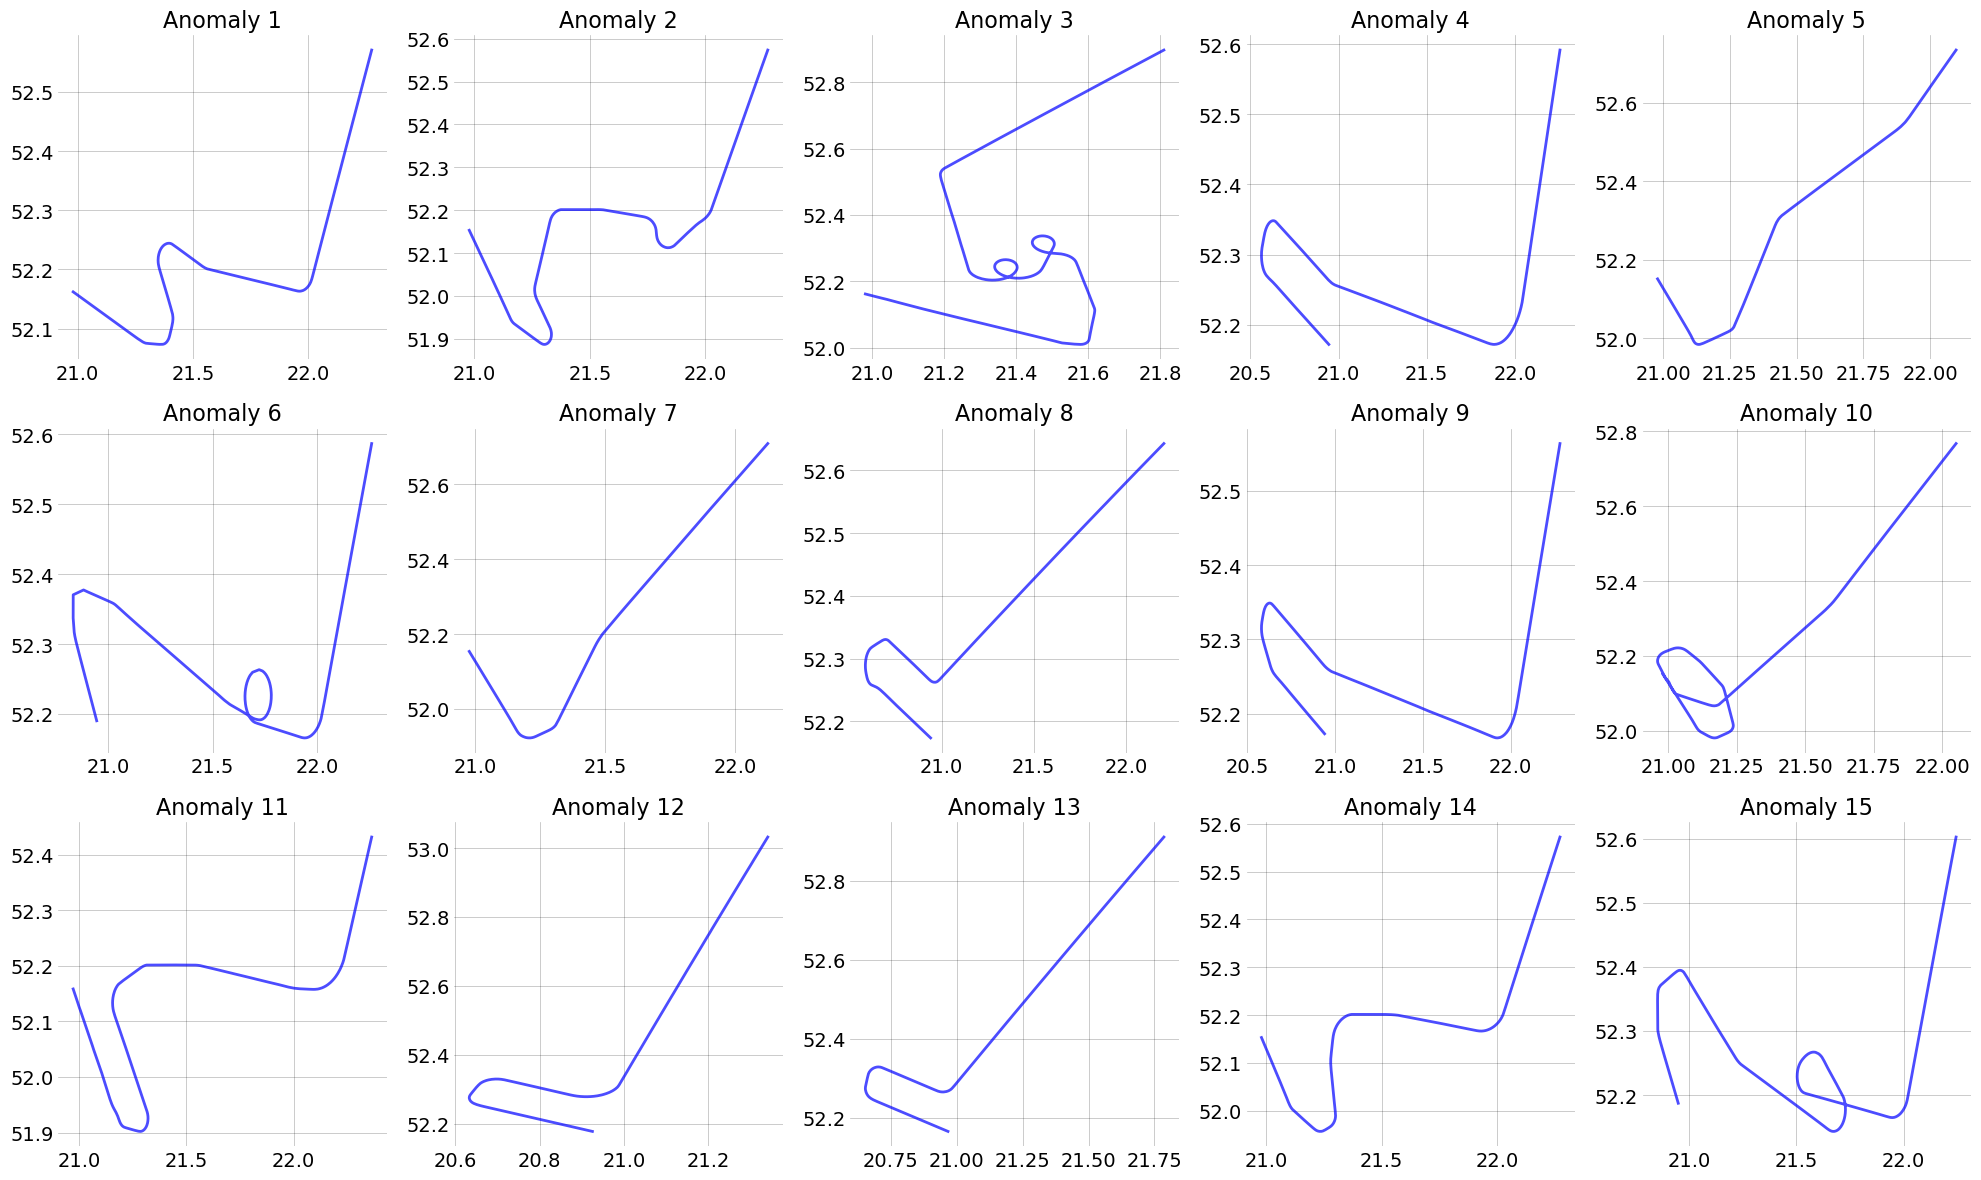

Callsign: LOT318, Clusters: 1, Noise: 7
Cluster labels: [-1  0]


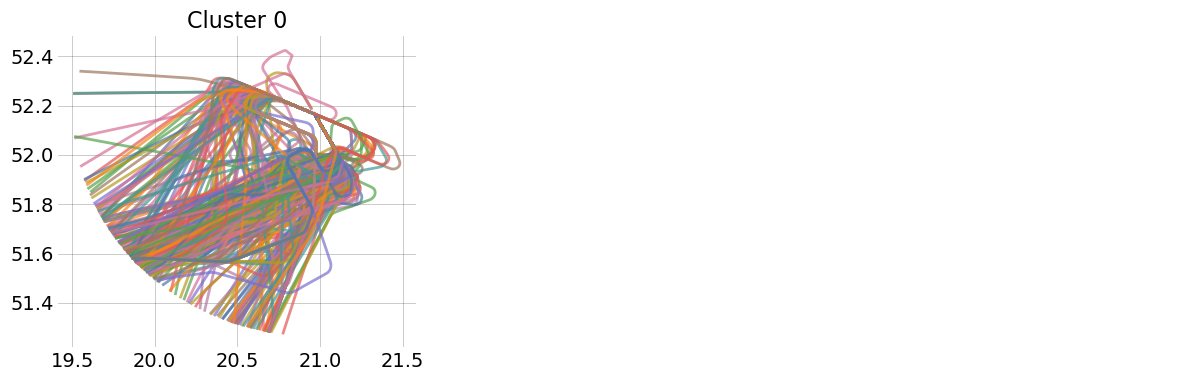

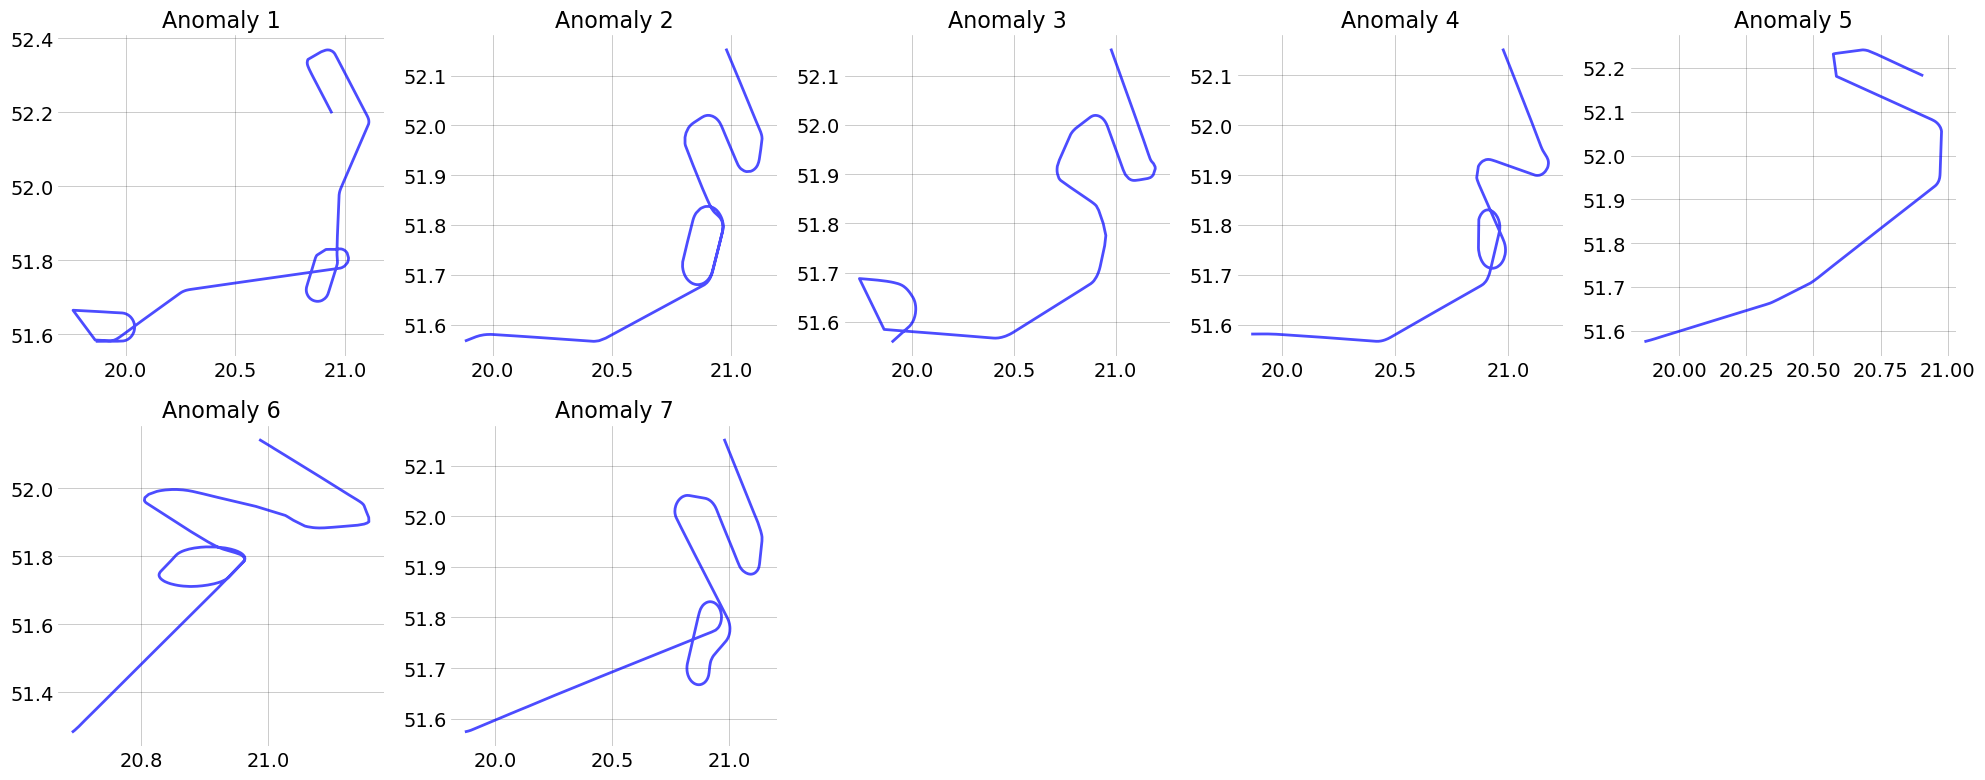

Callsign: LOT336, Clusters: 1, Noise: 21
Cluster labels: [-1  0]


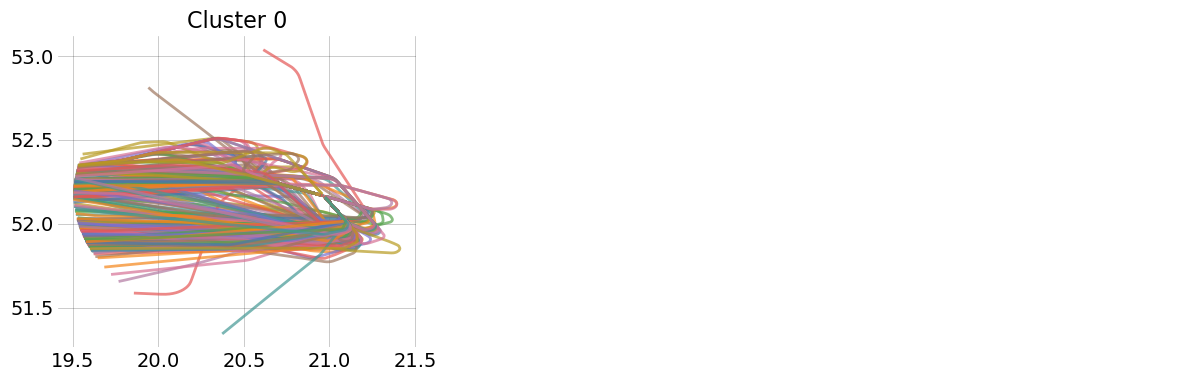

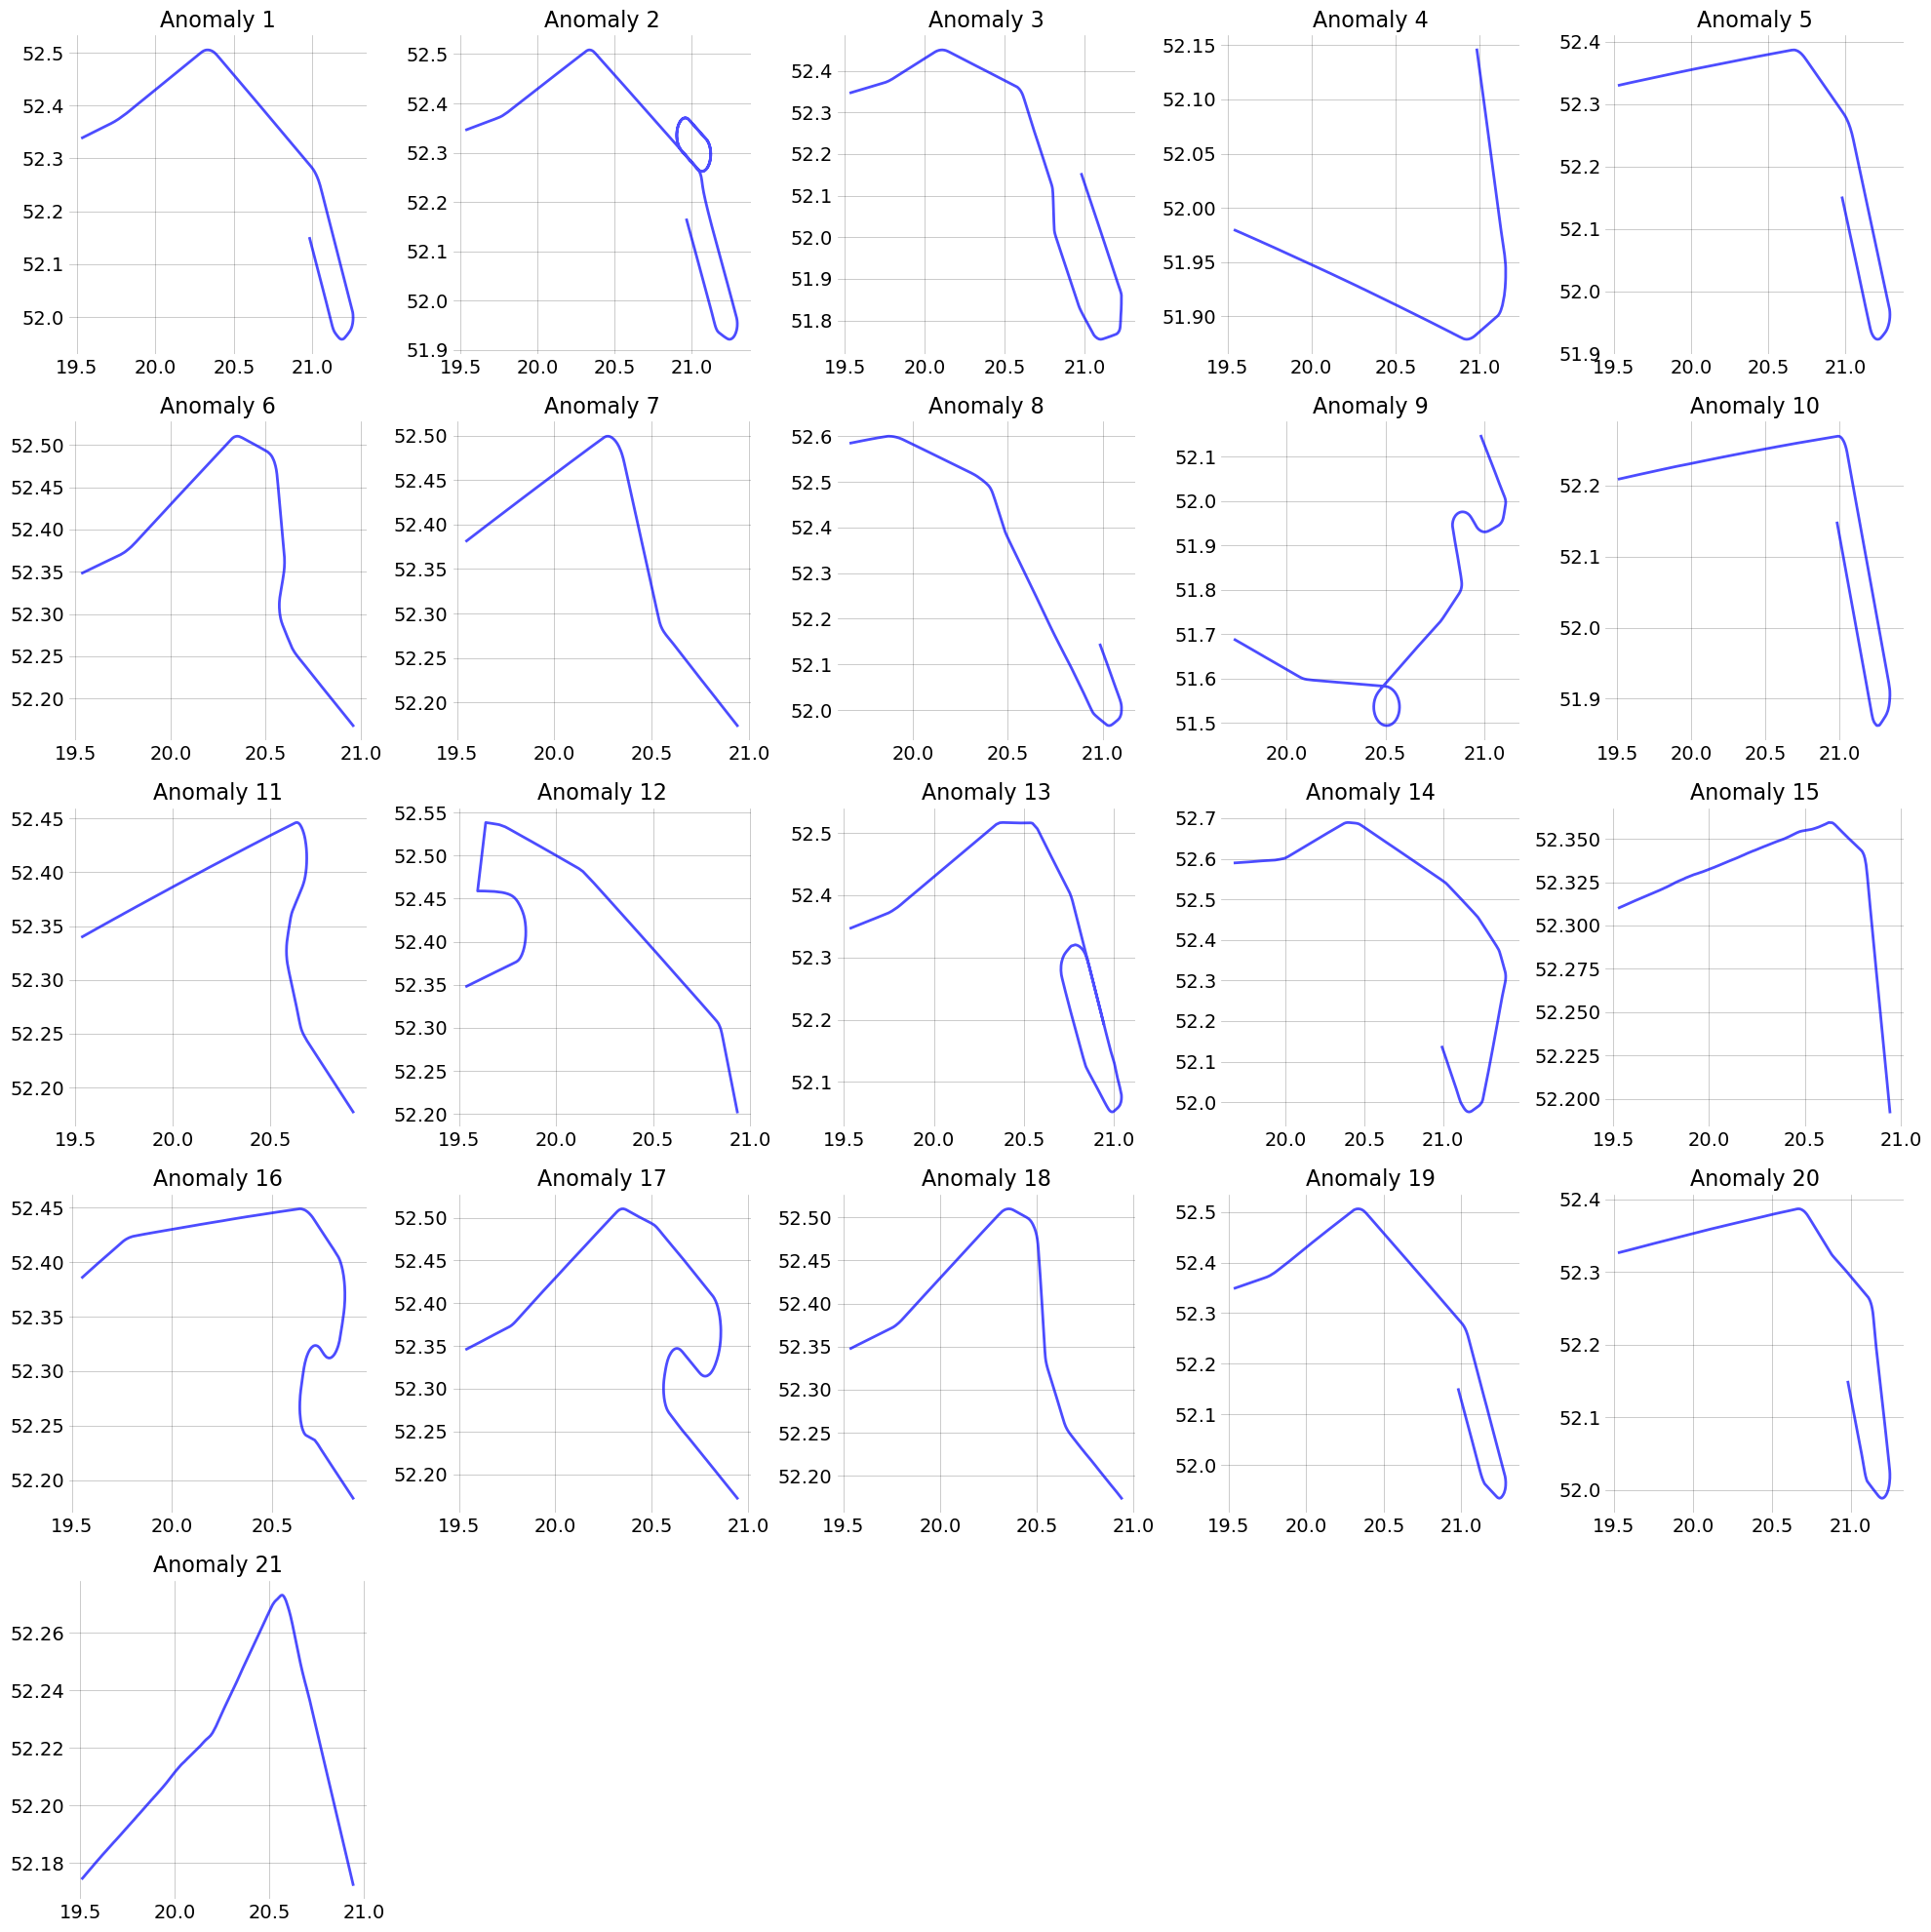

Callsign: LOT3WJ, Clusters: 1, Noise: 11
Cluster labels: [-1  0]


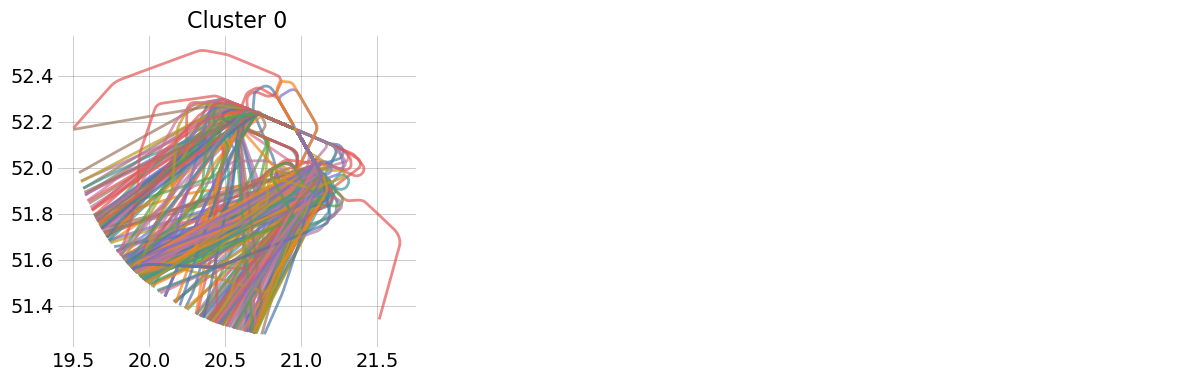

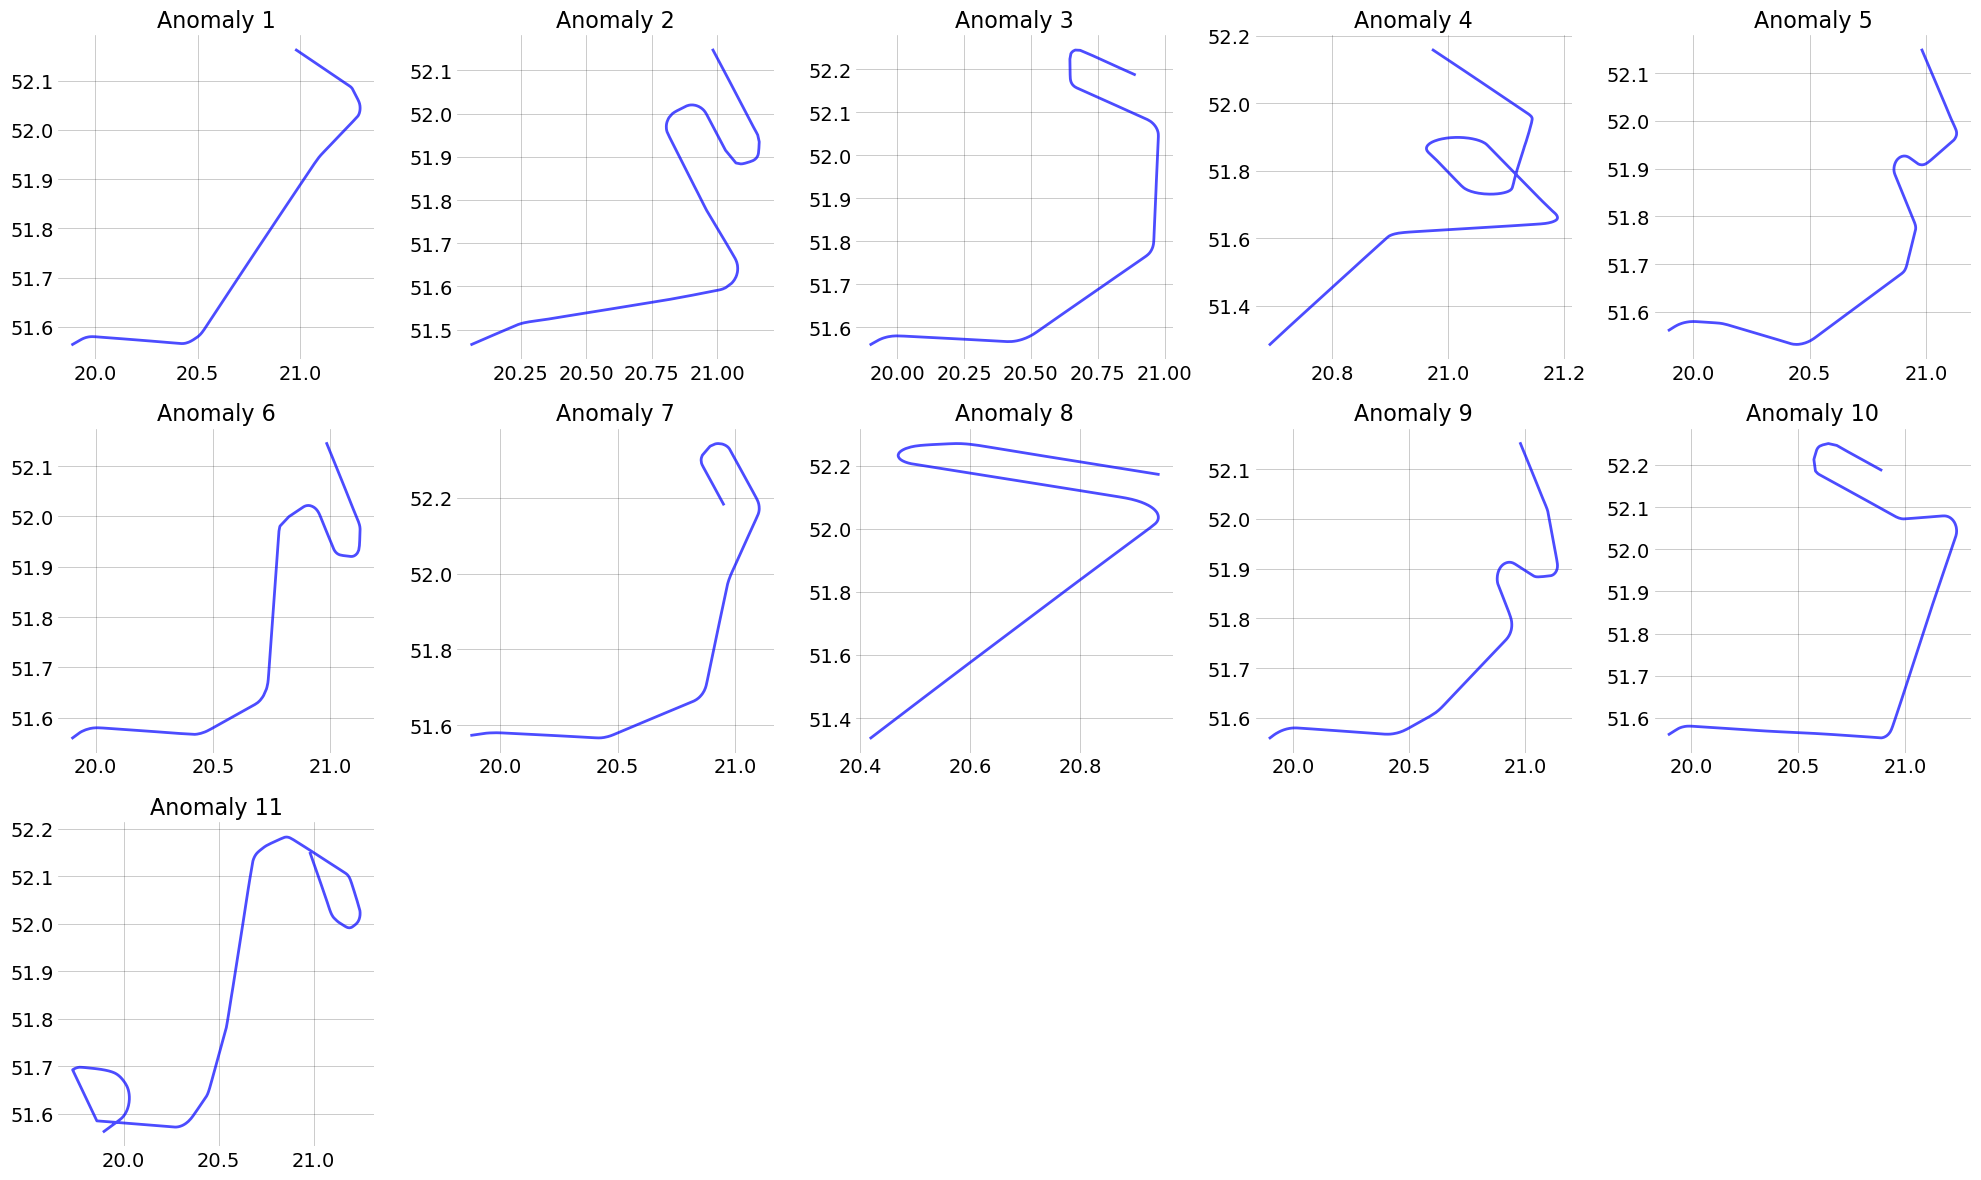

Callsign: LOT48F, Clusters: 1, Noise: 16
Cluster labels: [-1  0]


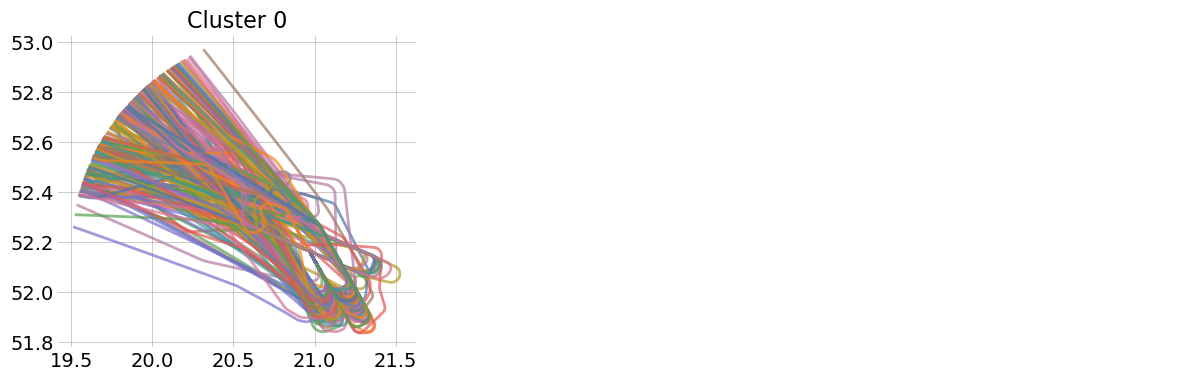

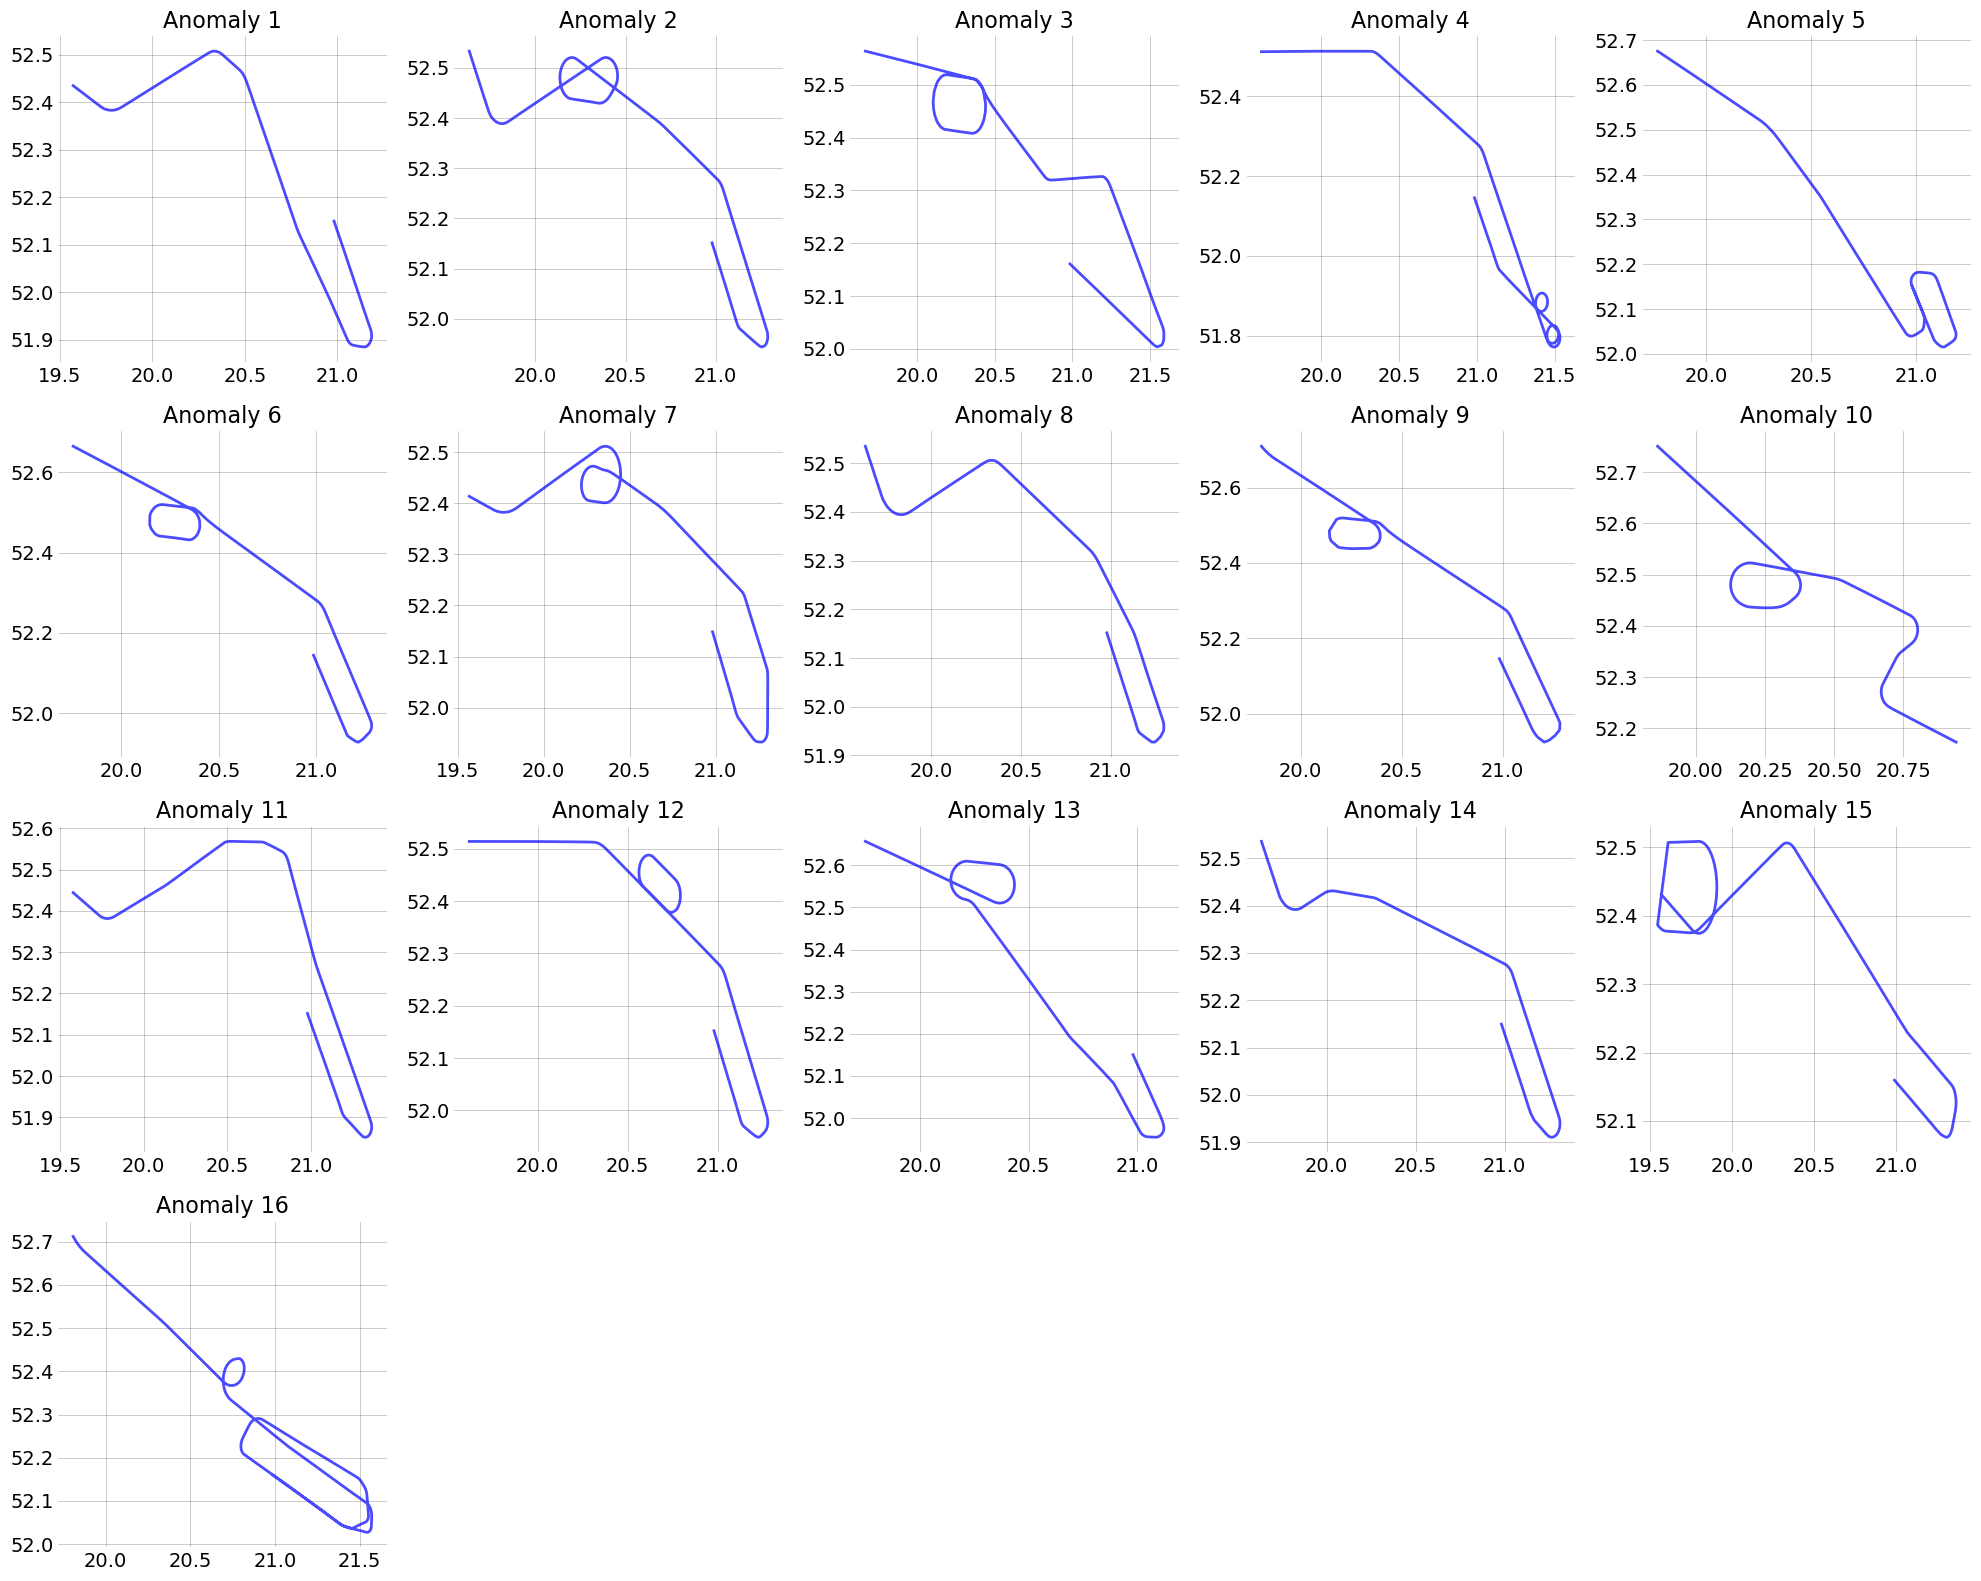

Callsign: LOT4LE, Clusters: 1, Noise: 9
Cluster labels: [-1  0]


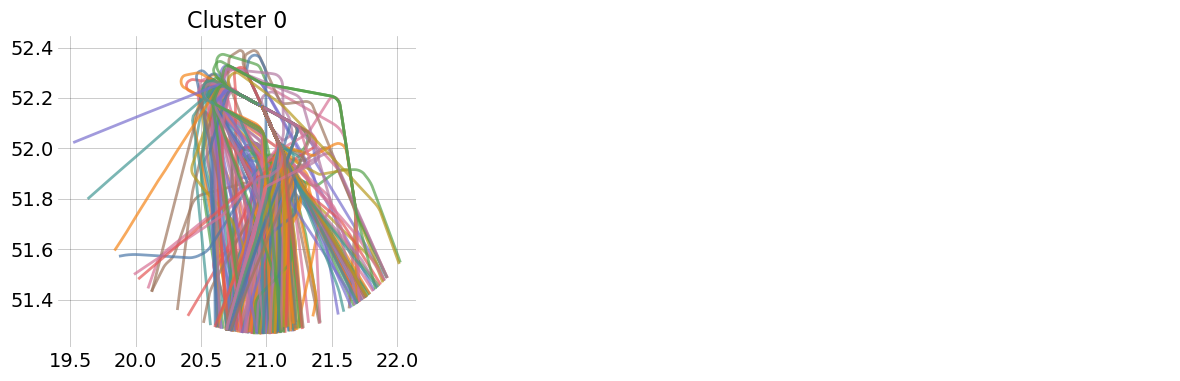

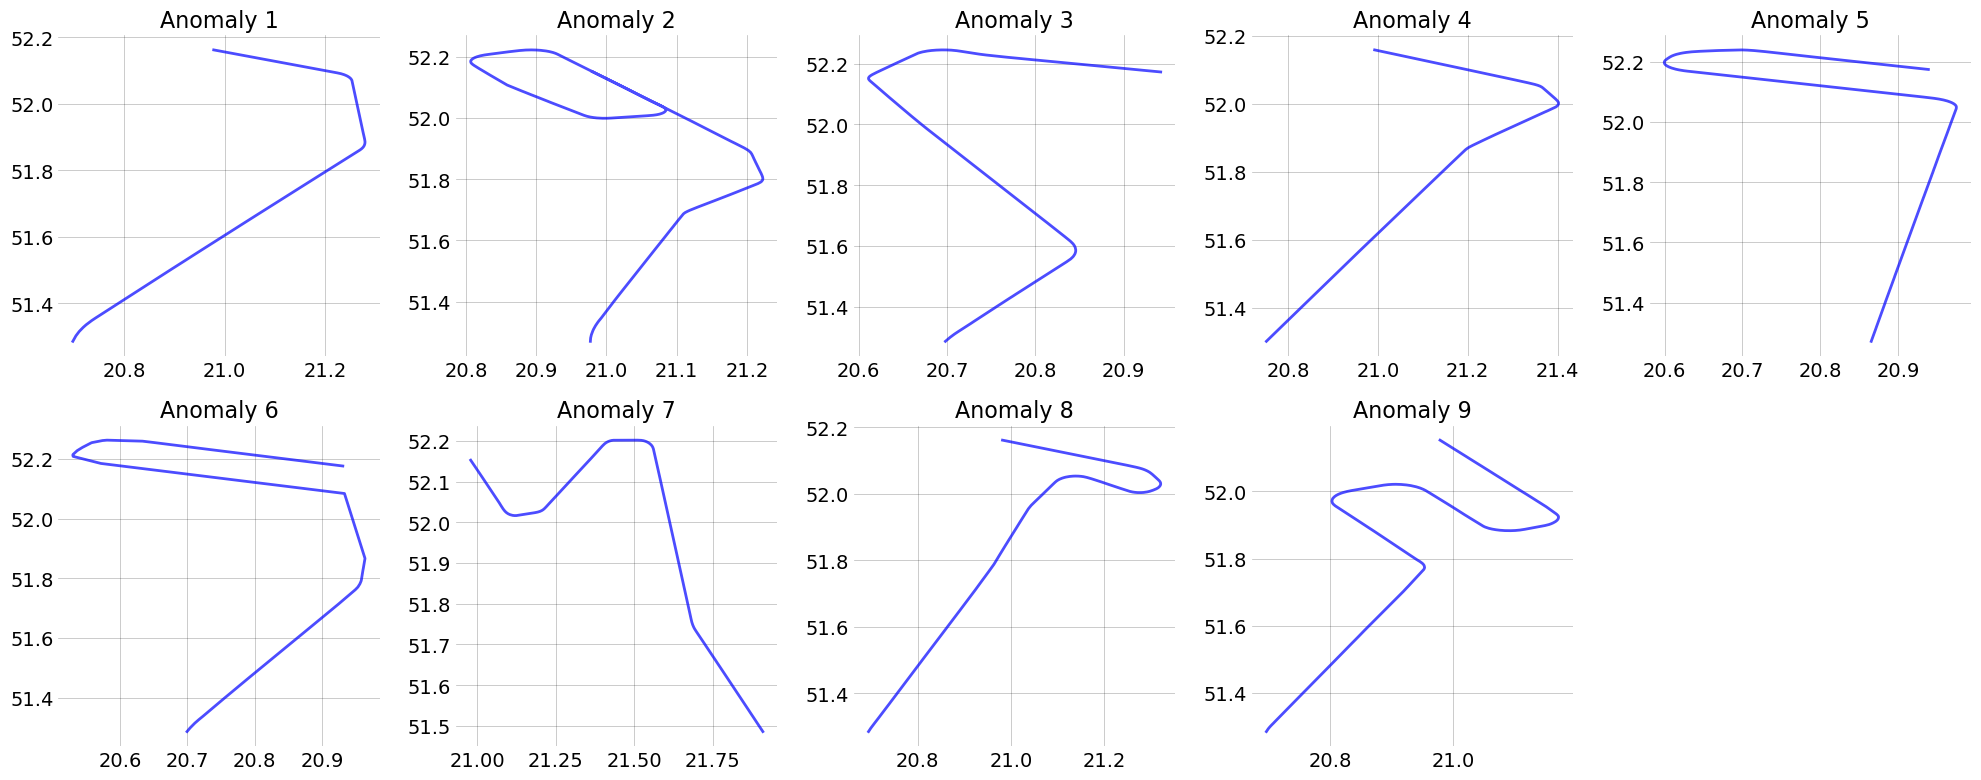

Callsign: LOT484, Clusters: 1, Noise: 12
Cluster labels: [-1  0]


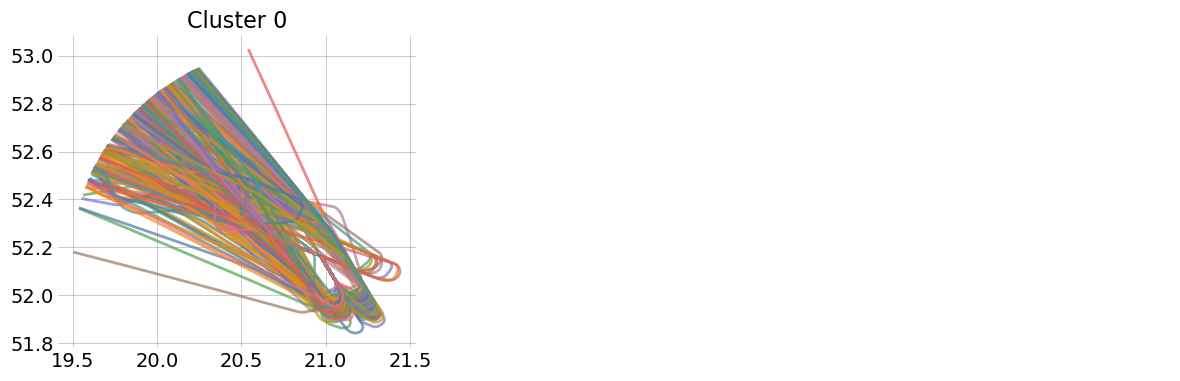

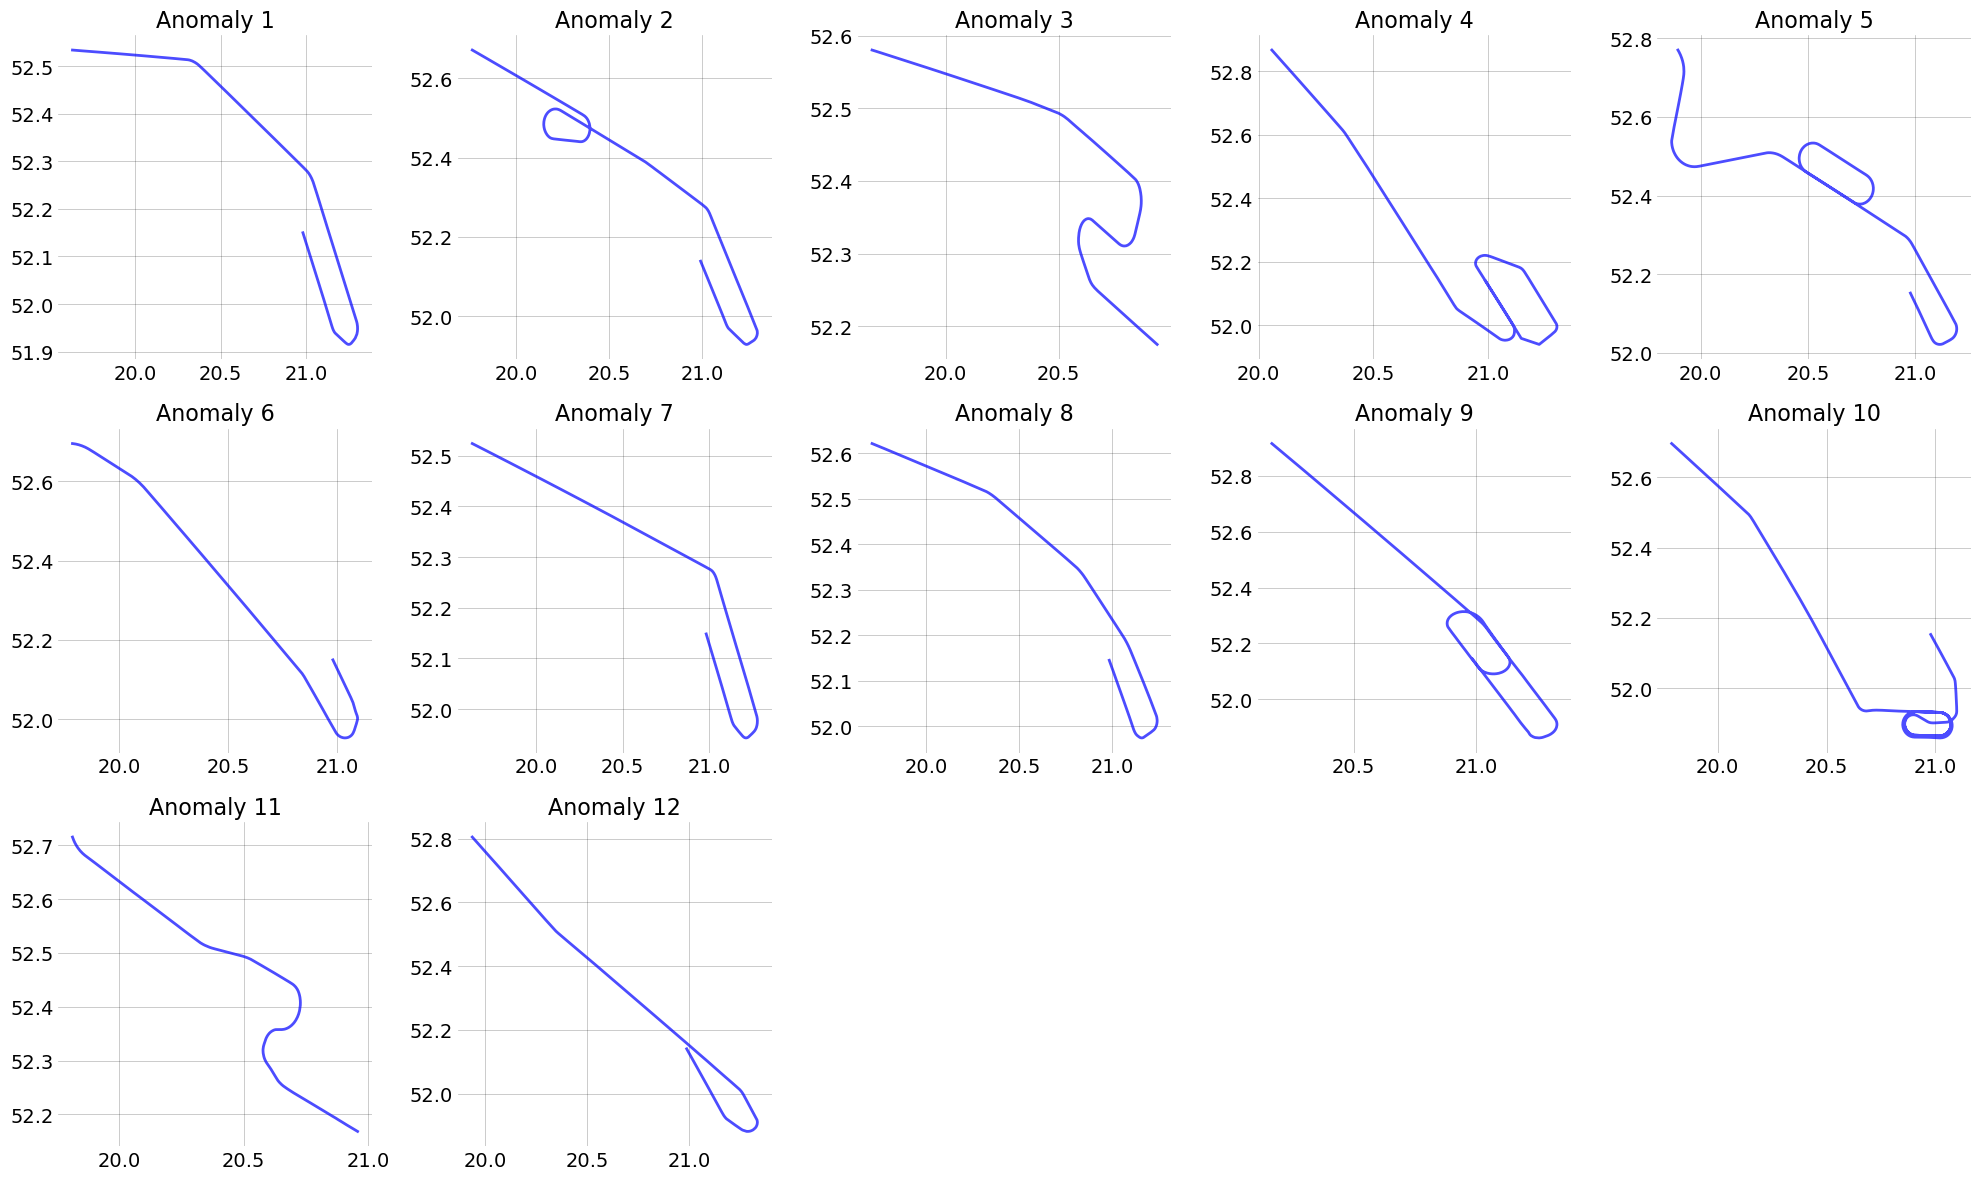

Callsign: LOT136, Clusters: 1, Noise: 5
Cluster labels: [-1  0]


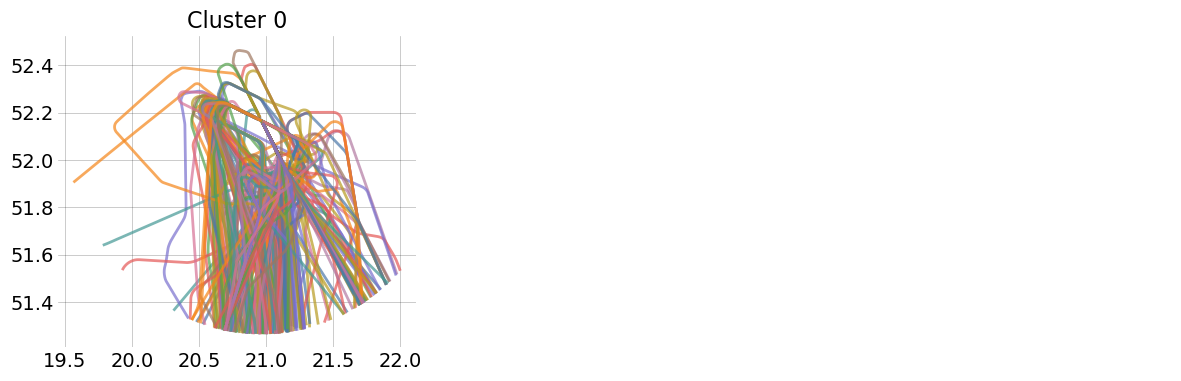

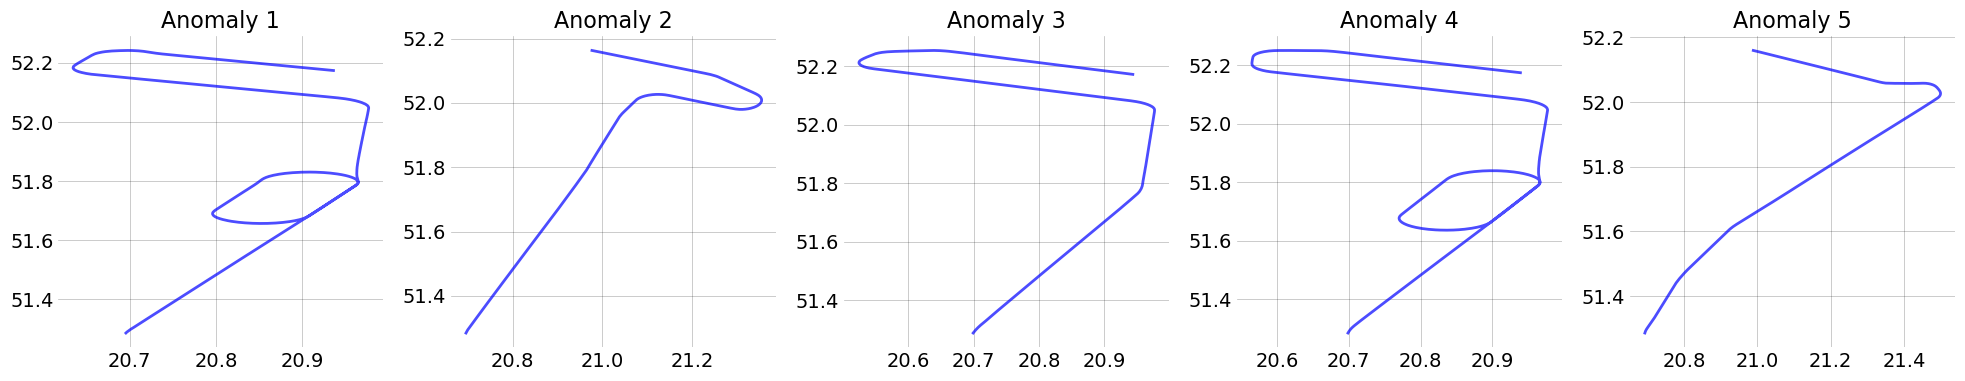

Callsign: LOT2LY, Clusters: 1, Noise: 9
Cluster labels: [-1  0]


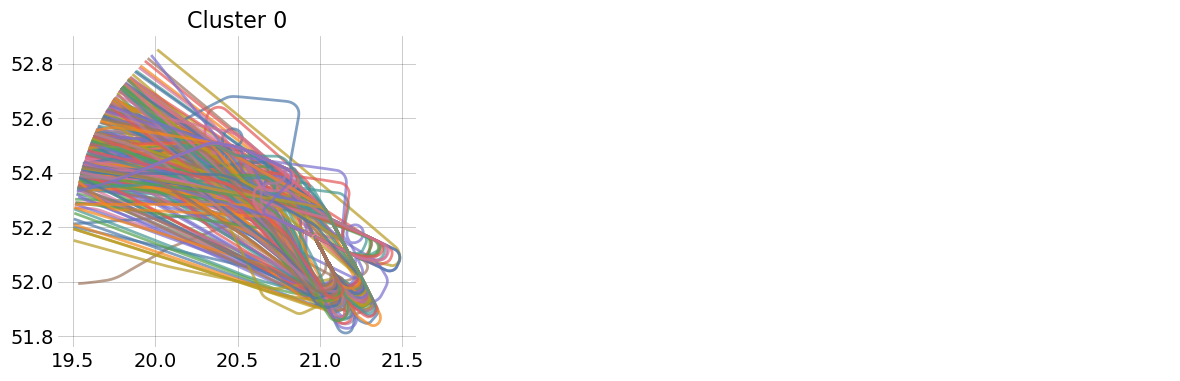

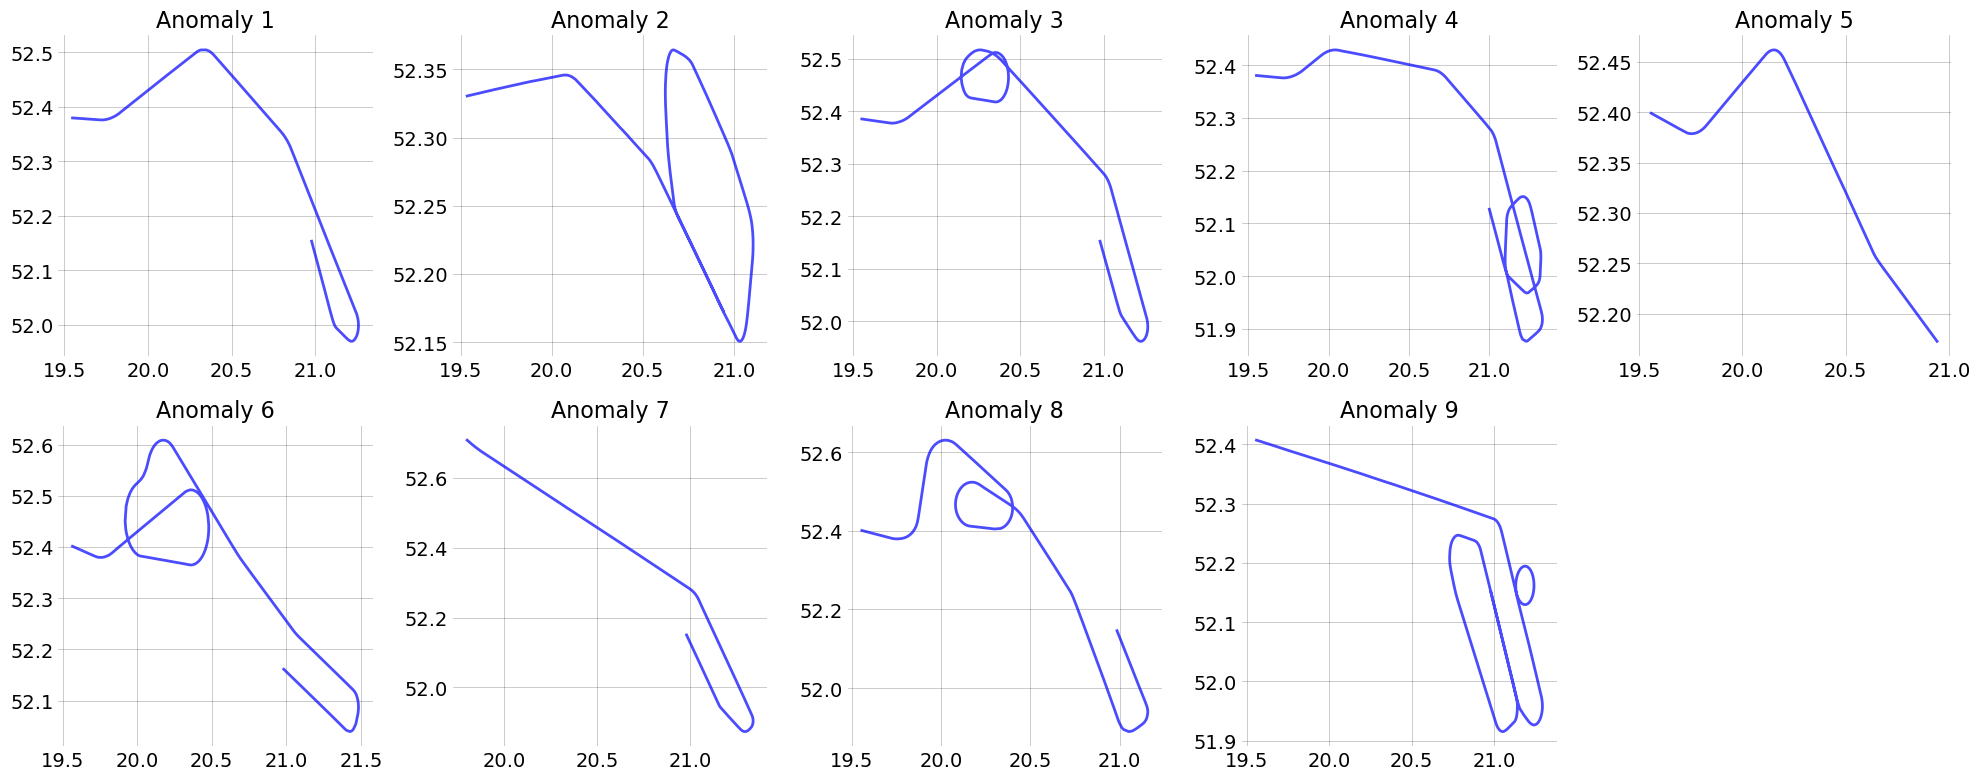

Callsign: FDB1829, Clusters: 1, Noise: 6
Cluster labels: [-1  0]


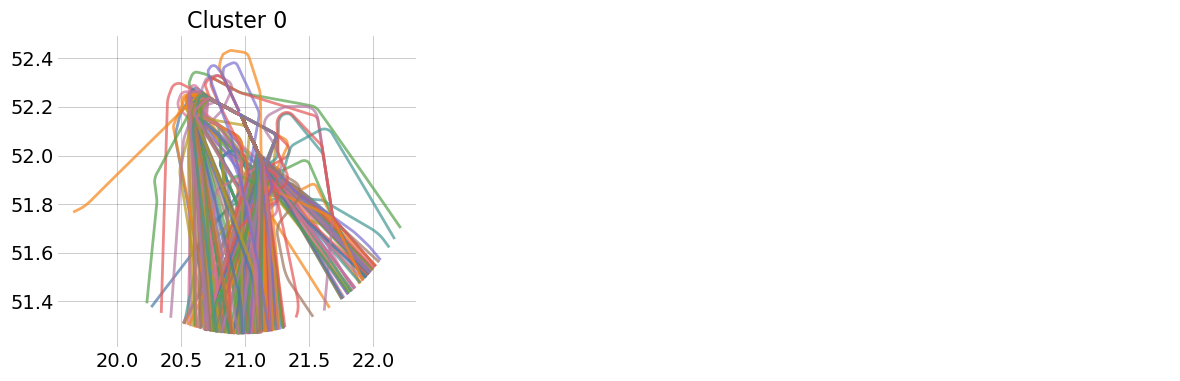

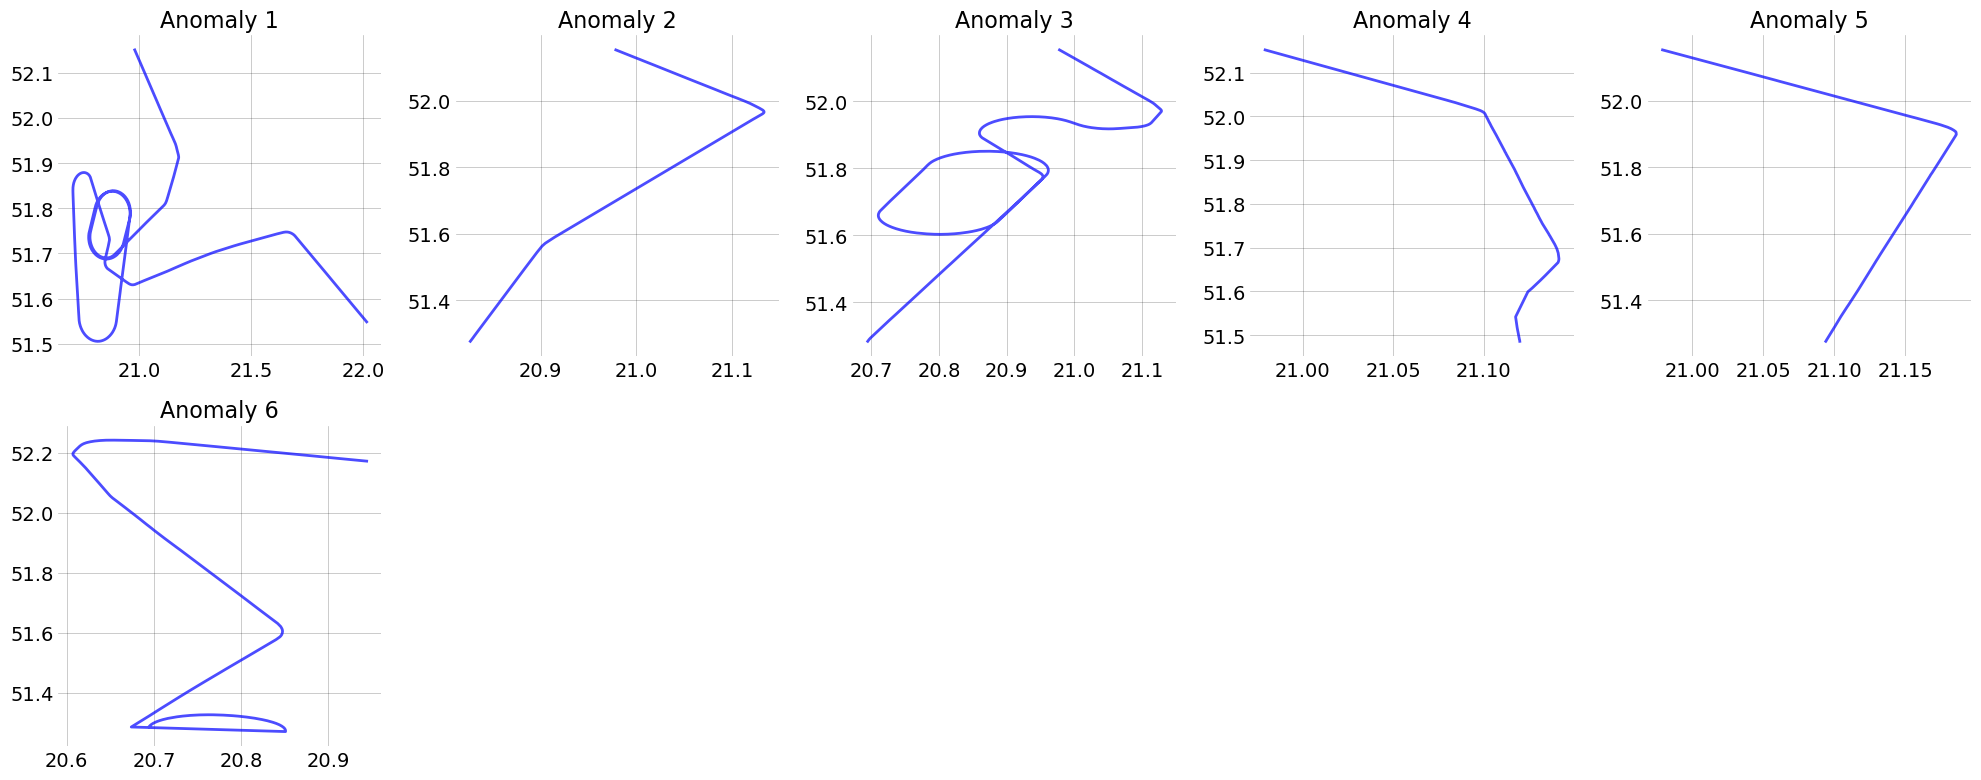

In [19]:
k = 5

os.makedirs("dtw_groundspeed_vertical", exist_ok=True)
os.makedirs("dtw_groundspeed_vertical/distance_matrices", exist_ok=True)

for callsign in sequences_by_callsign.keys():
    sequences = sequences_by_callsign[callsign]
    if len(sequences) < 2:
        continue
    distance_matrix = dtw_ndim.distance_matrix_fast(sequences)
    # Save distance matrix as parquet
    df_distance = pd.DataFrame(distance_matrix)
    df_distance.to_parquet(f"dtw_groundspeed_vertical/distance_matrices/{callsign}.parquet")
    nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(distance_matrix)
    distances, indices = nbrs.kneighbors(distance_matrix)
    k_distances = np.sort(distances[:, -1])
    kneedle = KneeLocator(range(len(k_distances)), k_distances, S=1.0, curve="convex", direction="increasing")
    elbow_value = kneedle.knee_y
    db = DBSCAN(eps=elbow_value, min_samples=5, metric='precomputed')
    labels = db.fit_predict(distance_matrix)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    print(f"Callsign: {callsign}, Clusters: {n_clusters}, Noise: {n_noise}")
    if n_clusters > 0:
        print(f"Cluster labels: {np.unique(labels)}")
        outlier_indices = np.where(labels == -1)[0]
        anomaly_flights = [flights_by_callsign[callsign][i] for i in outlier_indices]
        # Save anomalies as parquet
        anomaly_flights_traffic = Traffic.from_flights(anomaly_flights)
        anomaly_flights_traffic.to_parquet(f"dtw_groundspeed_vertical/{callsign}_anomalies.parquet")
        
        # Plot each cluster separately
        cluster_labels = [label for label in np.unique(labels) if label != -1]
        cluster_flights_list = []
        for label in cluster_labels:
            cluster_flights = [flights_by_callsign[callsign][i] for i in range(len(labels)) if labels[i] == label]
            cluster_flights_list.append(cluster_flights)

        # Plot all clusters on one grid
        n = len(cluster_labels)
        cols = 3
        rows = (n + cols - 1) // cols
        with plt.style.context('traffic'):
            fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
            axes = axes.flatten()
            for i, (label, cluster_flights) in enumerate(zip(cluster_labels, cluster_flights_list)):
                for flight in cluster_flights:
                    flight.plot(ax=axes[i], linewidth=2, alpha=0.7)
                axes[i].set_title(f'Cluster {label}')
            for j in range(i + 1, len(axes)):
                axes[j].axis('off')
            plt.tight_layout()
            plt.show()
        
        # Plot anomalies grid
        n = len(anomaly_flights)
        cols = 5
        rows = (n + cols - 1) // cols
        with plt.style.context('traffic'):
            fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
            axes = axes.flatten()
            for i, flight in enumerate(anomaly_flights):
                flight.plot(ax=axes[i], color='blue', linewidth=2, alpha=0.7)
                axes[i].set_title(f'Anomaly {i+1}')
            for j in range(i + 1, len(axes)):
                axes[j].axis('off')
            plt.tight_layout()
            plt.show()